<a href="https://colab.research.google.com/github/atkamara/deeplearning/blob/main/78actu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# I) Chargement des bibliothèques

In [ ]:
import datetime,geopandas,folium,networkx,hdbscan,random#pygoes
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.decomposition import NMF
from sklearn.metrics import roc_curve
from d2sntextmining import topics,\
                              nlp,\
                            utils,\
                            search,\
                            plot

/home/akamara/venvs/d2sntxtmining/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# II) Exploration des volumes d'articles

In [ ]:
actu78 = utils.pandas.read_csv('./data/78actu.csv',encoding='utf-8',sep='\t',usecols=['theme','datetime','ville'])
actu78.head()

,theme,ville,datetime
0,Société,Bois-d'Arcy,2022-04-07T20:21:23+02:00
1,Société,Meulan-en-Yvelines,2022-04-07T13:26:08+02:00
2,Société,Beynes,2022-04-07T12:35:39+02:00
3,Société,Yvelines,2022-04-07T09:58:52+02:00
4,Société,Beynes,2022-04-07T06:22:05+02:00


### II.1 Répartition temporelle des 1880 articles

In [ ]:
actu78.shape

(1880, 3)

<AxesSubplot:>

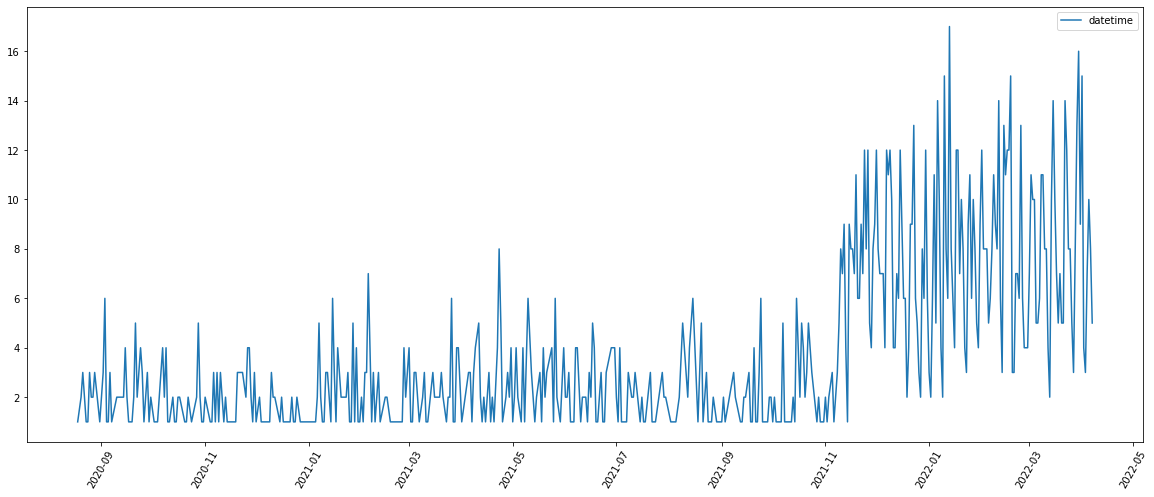

In [ ]:
dates = utils.pandas.to_datetime(actu78['datetime'],utc=True).dt.tz_convert(tz='Europe/Paris')

dates.dt.date.value_counts().to_frame().sort_index().plot(rot=60,figsize=(20,8))

#### L'essentiel des articles ont été publiés en 2022 en raison probablement de l'extraction tardive de ceux-ci effectué à la date du 08/04/2022

/tmp/ipykernel_18845/2292886424.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  semaine = dates.dt.week,


<AxesSubplot:title={'center':'Moyenne journalière des publications quotidiennes semaine vs weekend'}, xlabel='datetime'>

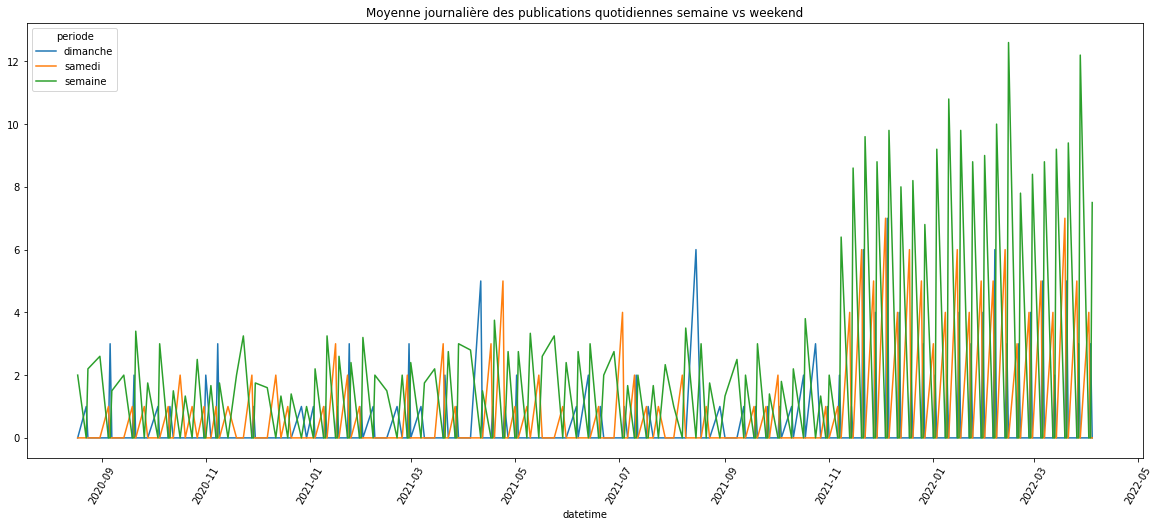

In [ ]:
dates.dt.date.to_frame(
    ).assign(
    annee = dates.dt.year,
    semaine = dates.dt.week,
     periode = utils.pandas.Series(utils.numpy.select([dates.dt.day_of_week==5,dates.dt.day_of_week==6],('samedi','dimanche'),default='semaine'))

    ).groupby(['datetime','annee','semaine','periode']).size().reset_index().rename(columns={0:'count'}
        ).groupby(['annee','semaine','periode']

    ).agg({'count':'mean','datetime':'min'}).reset_index(

    ).pivot_table(index='datetime',columns='periode',aggfunc='mean',values='count').fillna(0).plot(rot=60,figsize=(20,8),title='Moyenne journalière des publications quotidiennes semaine vs weekend')

#### Le volume de publications par jour est naturellement plus important en semaine que durant le weekend notamment durant la période la plus représentative en termes de données(2022)

### II.2 Articles par thème & filtre des données initiales

<AxesSubplot:>

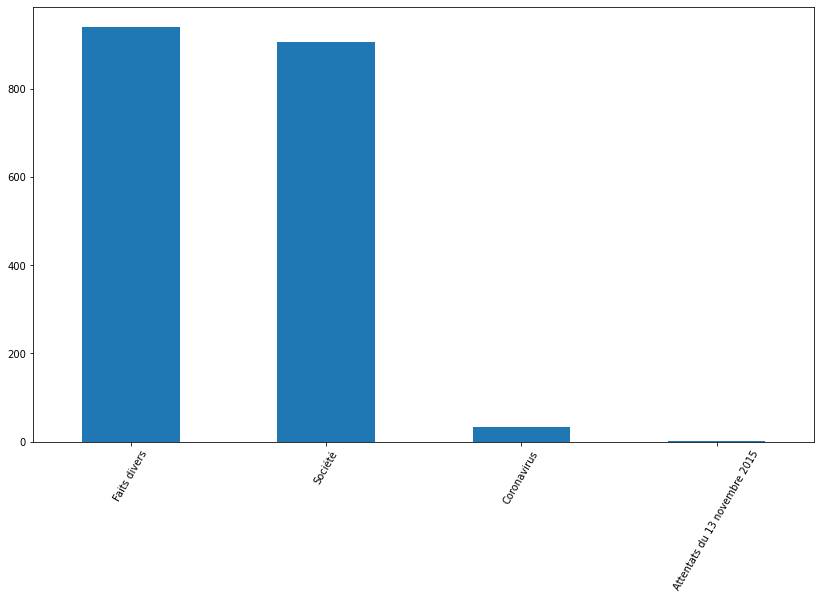

In [ ]:
actu78.theme.value_counts().plot(kind='bar',rot=60,figsize=(14,8))

#### nous allons nous focaliser uniquement sur les faits divers et les articles de société

In [ ]:
good_themes = ['Faits divers','Société']
actu78 = actu78.query('theme in @good_themes')
actu78 = actu78.query('ville !="Yvelines" ')
print(f'Les Articles non traités correspondent à  {(1-actu78.shape[0]/1880)*100:.2f}% du jeu de données initial\n',
      f'reste : {actu78.shape[0]}')

Les Articles non traités correspondent à  8.83% du jeu de données initial
 reste : 1714


### II.3 Répartition des 1714 Articles par ville

<AxesSubplot:title={'center':'Villes les plus représentées(835 articles(48.72%) )'}>

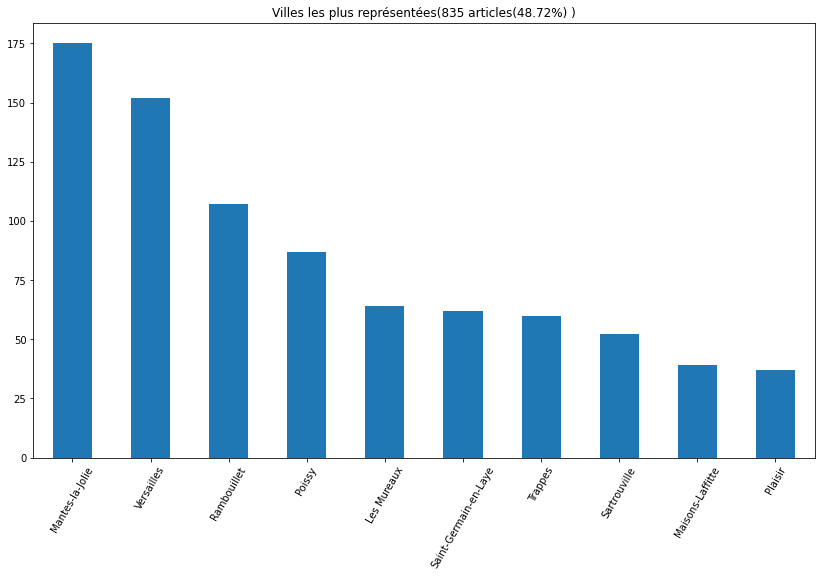

In [ ]:
towns = actu78.ville.value_counts()
towns.head(10).pipe(lambda D : D.plot(kind='bar',rot=60,figsize=(14,8),title=f'Villes les plus représentées({D.sum()} articles({D.sum()*100/towns.sum():.2f}%) )'))

#### On dénombre presque la moitié des articles qui porte sur le top 10 des villes

159/262 communes des yvelines

description du nombre d'articles
 count    159.000000
mean      10.616352
std       22.980674
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      175.000000
Name: Nb_articles, dtype: float64


<AxesSubplot:title={'center':'Distribution articles par ville'}, ylabel='Frequency'>

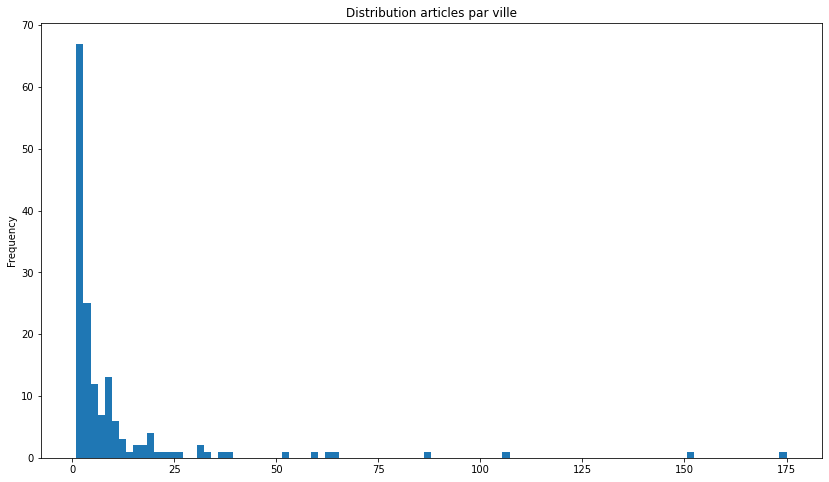

In [ ]:
towns = towns.to_frame().reset_index().rename(columns={'index':'Ville','ville':'Nb_articles'})
geo   = utils.pandas.read_csv('./data/geo.csv',usecols=['given_address','lat','lon','city']).assign(Ville=lambda D : D.given_address.str.split(',').str[0].str.strip())
towns = towns.merge(geo,on='Ville').query('city.notnull()')
towns = geopandas.GeoDataFrame(towns,geometry=geopandas.points_from_xy(towns.lon,towns.lat),crs='EPSG:4326')
print(f'{towns.shape[0]}/262 communes des yvelines\n')
print("description du nombre d'articles\n",towns.Nb_articles.describe())
towns.Nb_articles.plot(kind='hist',title='Distribution articles par ville',figsize=(14,8),bins=100*towns.Nb_articles.min())

In [ ]:
polygons = geopandas.read_file('https://france-geojson.gregoiredavid.fr/repo/departements/78-yvelines/communes-78-yvelines.geojson',crs='EPSG:4326')
towns    = geopandas.sjoin(towns,polygons,how='right').query('city.notnull()')
m        = folium.Map(location=(48.7, 1.89), zoom_start=9)
folium.TileLayer(tiles='CartoDB positron').add_to(m)
m.choropleth(
                                                         geo_data=towns,
                                                         name='Choropleth',
                                                         data=towns,
                                                         columns=['Ville','Nb_articles'],
                                                         key_on="feature.properties.Ville",
                                                         fill_color='YlGnBu',
                                                         threshold_scale=(1,10,20,40,50,100,180),
                                                         fill_opacity=0.65,
                                                         line_opacity=0.2,
                                                         legend_name='Articles publiés sur les villes yvelinoises',
                                                         smooth_factor=0
                                                        )
m

/home/akamara/venvs/d2sntxtmining/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


#### Les écarts de distribution sont très marqués entre les villes les plus citées et les villes "normalement" citées
#### On note une importante focalisation des articles sur seulement une partie des villes du département

# III Traitement lexicométrique des articles

In [ ]:
h = utils.html2text.HTML2Text()
h.ignore_links= True
paragraphs_out ="  _cet article vous a été utile ? sachez que vous pouvez suivre 78actu dans l’espacemon actu . en un clic, après inscription, vous y retrouverez toute l’actualité de vos villes et marques favorites._  "
querieddf = lambda : utils.pandas.read_csv('./data/78actu.csv',encoding='utf-8',sep='\t').query('theme in @good_themes').query('ville !="Yvelines" ')
Tx_raw = lambda : querieddf().paragraphs.apply(h.handle).str.replace('*','',regex=False).str.replace('\n',' ').str.lower().str.replace(paragraphs_out,'',regex=False).reset_index(drop=True)

len(Tx_raw())

1714

<AxesSubplot:title={'center':'distribiution du nombre de caractères brut'}, ylabel='Frequency'>

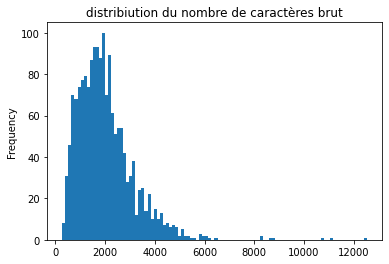

In [ ]:
Tx_raw().str.strip().str.len().plot(kind='hist',bins=100,title='distribiution du nombre de caractères brut')

## III. 1) Extraction brutes des éléments de langage naturel

### III.1.1) computation des lemmes

In [ ]:
nlpprocessor = nlp.NLP(model_name='fr_core_news_md',
                       enabled_pipes=["tok2vec","morphologizer","parser","attribute_ruler","lemmatizer","ner","language_detector"]
                      )

In [ ]:
%%time

GN = [
        ['GN_2',[[{'RIGHT_ID': 'nom_tête', 'RIGHT_ATTRS': {'POS': 'NOUN'}}, {'LEFT_ID': 'nom_tête', 'REL_OP': '>', 'RIGHT_ID': 'dépendance', 'RIGHT_ATTRS': {'DEP': {'IN': ['amod', 'nmod']}}}]]],
        ['GN_3',[[{'RIGHT_ID': 'nom_tête', 'RIGHT_ATTRS': {'POS': 'NOUN'}}, {'LEFT_ID': 'nom_tête', 'REL_OP': '>', 'RIGHT_ID': 'dépendance_1', 'RIGHT_ATTRS': {'DEP': {'IN': ['amod', 'nmod']}}}, {'LEFT_ID': 'dépendance_1', 'REL_OP': '>', 'RIGHT_ID': 'dépendance_2', 'RIGHT_ATTRS': {'DEP': {'IN': ['amod', 'nmod']}}}]]]
]
nlpprocessor.process_texts(  raw_texts_list=Tx_raw(),
                                           GN = GN,
                                      pipeargs = {'batch_size':28,'n_process':2}) #GN default []
nlpprocessor.extract_docs_attributes(max_workers=1)

100%|█████████████████████████████████████████████████████████| 1714/1714 [00:01<00:00, 1255.16it/s]

CPU times: user 14 s, sys: 431 ms, total: 14.4 s
Wall time: 1min 10s


In [ ]:
nlpprocessor.n_processed

1714

100%|█████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 3136.99it/s]


<AxesSubplot:>

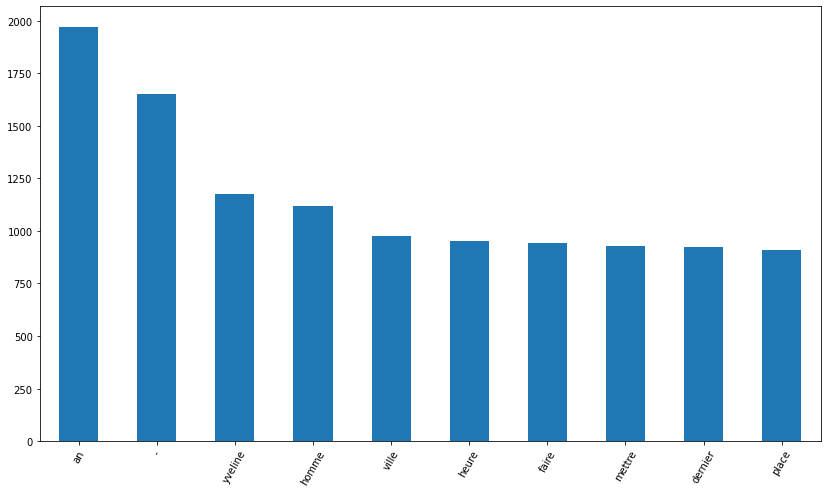

In [ ]:
languages = ['fr']
keep_col  = 'lemma'
full_cats = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'VERB', 'X']

dq         = [lambda d,i : d[i.index('pos')] in full_cats,lambda d,i : not d[i.index('is_stop')] ]
lemmas,lemmas_value_counts = nlpprocessor.extract_docs_element(
                                                                col_name=keep_col,
                                                                filters=dq,
                                                                distinct_counts  = True,
                                                                languages = languages,
                                                            raw_texts_list = Tx_raw(),
                                                                for_loop=True)
lemmas_value_counts.head(10).plot(figsize=(14,8),kind='bar',rot=60)

### III.1.1) Recherche des groupes nominaux

1714it [00:12, 133.58it/s]
1714it [00:12, 133.14it/s]
1714it [00:30, 56.50it/s]
1714it [00:04, 412.47it/s]


<AxesSubplot:title={'center':'bigrams'}, ylabel='phrase'>

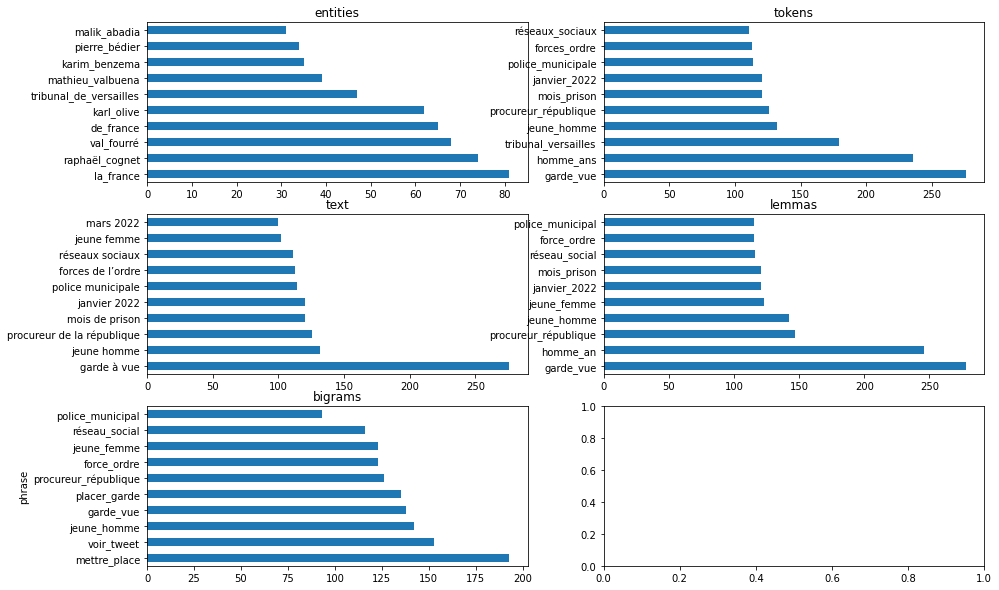

In [ ]:
lemma_gns,lemma_gns_value_counts  = nlpprocessor.extract_docs_element(nophrase=False,distinct_counts=True,col_name='lemma')
tkn_gns,tkn_gns_value_counts      = nlpprocessor.extract_docs_element(nophrase=False,distinct_counts=True)
txt_gns,txt_gns_value_counts      = nlpprocessor.extract_docs_element(nophrase=False,distinct_counts=True,col_name='idx',raw_texts_list = Tx_raw())
ent_gns,ent_gns_value_counts      = nlpprocessor.extract_docs_element(nophrase=False,distinct_counts=True,element_type='entities')
bigrams_gns,\
    bigrams_gns_value_counts,\
               bigrams_gns_scores = nlp.bigram(lemmas,bgargs={'min_count':5, 'threshold':3,'scoring':'default'})
fig,axes = plot.plt.subplots(nrows=3,ncols=2,figsize=(15,10))
ent_gns_value_counts.head(10).plot(ax=axes[0,0],kind='barh',title='entities')
tkn_gns_value_counts.head(10).plot(ax=axes[0,1],kind='barh',title='tokens')
txt_gns_value_counts.head(10).plot(ax=axes[1,0],kind='barh',title='text')
lemma_gns_value_counts.head(10).plot(ax=axes[1,1],kind='barh',title='lemmas')
bigrams_gns_value_counts.head(10).plot(ax=axes[2,0],kind='barh',title='bigrams')


### III.1.2) Ajout des groupes nominaux aux lemmes

#### III.1.2.1) Groupes nominaux syntaxiques tirés des formes lémmatisées

In [ ]:
syntax_gns  = lemma_gns_value_counts.pipe(lambda X : X[X>=10])

In [ ]:
syntax_gns.sort_values()

intervention_pompier     10
avenue_europe            10
quartier_-               10
mère_enfant              10
vendredi_premier         10
                       ... 
jeune_femme             123
jeune_homme             142
procureur_république    147
homme_an                246
garde_vue               278
Length: 588, dtype: int64

#### III.1.2.2) Bigrammes :
Seuil pondéré fréquence et score fixé à 3 après appréciation qualitative

<AxesSubplot:ylabel='Frequency'>

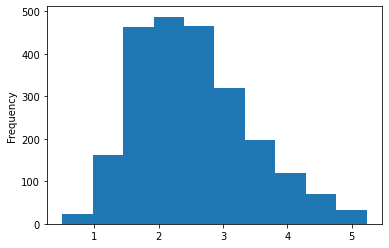

In [ ]:
bigrams_gns = (utils.numpy.log10(bigrams_gns_value_counts)+ utils.numpy.log10(bigrams_gns_scores))#.pipe(lambda X : X[X>=10])
bigrams_gns.plot(kind='hist')

In [ ]:
bigrams_gns[bigrams_gns>3].sort_values()

phrase
territoire_français    3.000001
police_judiciaire      3.000247
liberté_expression     3.001096
rue_paul               3.002073
domicile_familial      3.003628
                         ...   
sidi_el                5.102913
raphaël_cognet         5.107707
pronostic_vital        5.146780
gérald_darmanin        5.202298
karl_olive             5.230575
Length: 635, dtype: float64

In [ ]:
bigrams_gns = bigrams_gns[bigrams_gns>3]
len(bigrams_gns)

635

In [ ]:
gns         = utils.pandas.concat([bigrams_gns.index.to_series(),syntax_gns.index.to_series()]).drop_duplicates().str.split('_').tolist()
len(gns)

988

#### III.1.2.3) Recherche des séquences des groupes nominaux dans l'ensemble de lemmes de base

100%|██████████████████████████████████████████████████████████| 1714/1714 [00:04<00:00, 358.73it/s]


<AxesSubplot:title={'center':'Groupes de mots retrouvés'}>

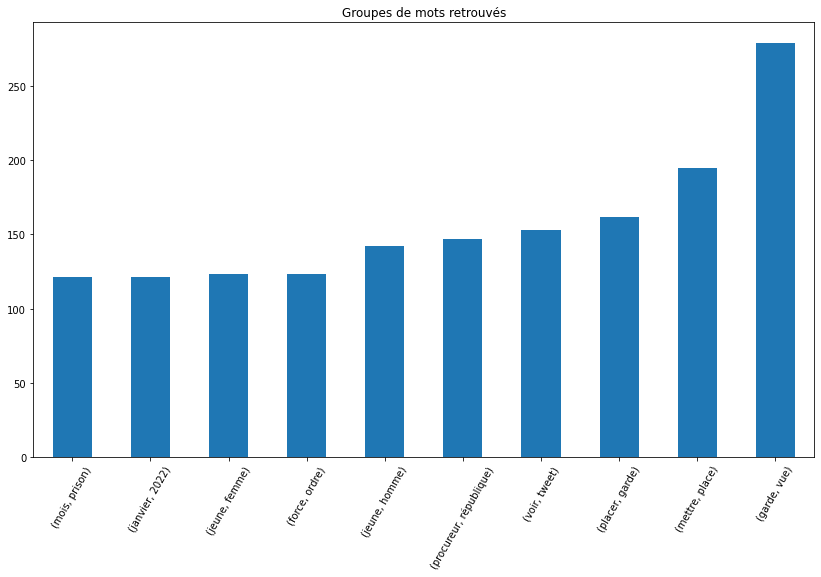

In [ ]:
Sfinder   = search.Finder(subs=gns)
found     = Sfinder.search(lemmas)
found.applymap(len).sum().sort_values().tail(10).plot(kind='bar',title='Groupes de mots retrouvés',rot=60,figsize=(14,8))


In [ ]:
found.applymap(len).sum().shape[0] == len(gns)

True

#### III.1.2.3) Remplacement dans base de lemmes initiale

In [ ]:
lemmas    = [utils.switcher(lemmas[i],found.loc[i][(found.applymap(len)>0).loc[i]].values) for i,L in utils.tqdm.tqdm(enumerate(lemmas))]

1714it [16:24,  1.74it/s]


In [ ]:
list(filter(lambda x : len(x.split('_'))>1,lemmas[0]))

['réfugié_ukrainien',
 'salle_bain',
 'basif_service',
 'quitter_pays',
 'dentifrice_papier',
 'décide_arrivée',
 'chamboule_monde',
 'mettre_place',
 'entraide_fort']

<AxesSubplot:title={'center':'distribiution du nombre de lemmes'}, ylabel='Frequency'>

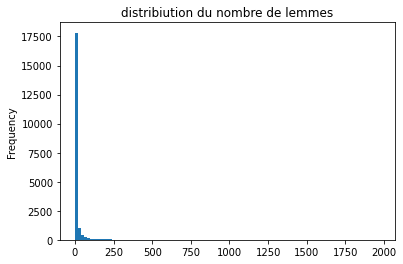

In [ ]:
lemmas_value_counts.plot(kind='hist',bins=100,title='distribiution du nombre de lemmes')

# IV) Réseau yvelinois des co-citations

## IV.1) extraction des entités nommés de localisation

In [ ]:
entities,entities_value_counts = nlpprocessor.extract_docs_element(
                                                                element_type ='entities',
                                                                col_name='text',
                                                                filters=[lambda d,i : d[i.index('label')] == 'LOC' ],
                                                                distinct_counts  = True,
                                                            raw_texts_list = Tx_raw(),
                                                                for_loop=True)

100%|███████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 157402.34it/s]


In [ ]:
print(f'{entities_value_counts.shape[0]} entités de localisation retrouvés avec peut-être des orthographes différents')

2359 entités de localisation retrouvés avec peut-être des orthographes différents


<AxesSubplot:>

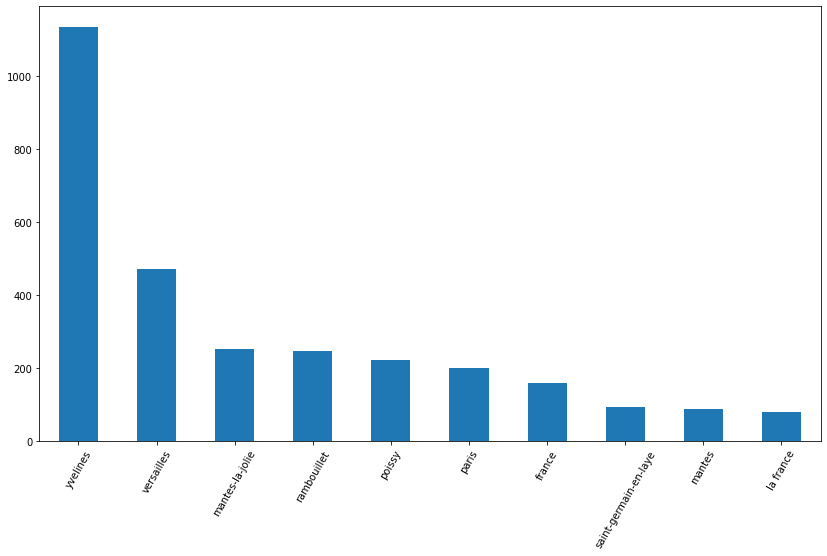

In [ ]:
entities_value_counts.head(10).plot(figsize=(14,8),kind='bar',rot=60)

## IV.2) Recherche de similarités entre entités nommées et l'écriture normale des villes

### IV.2.1) Exemple de Versailles, nous allons nous interesser aux co-occurrences des lettres prises successivement avec remise par groupes de 3

#### 47 entités nommés détectés contenant la ville versailles

In [ ]:
print(entities_value_counts.index.to_series().pipe(lambda c : c[c.str.contains('versailles')]).tolist())

['versailles', 'château de versailles', 'commissariat de versailles', 'république de versailles', 'versailles grand parc', 'université de versailles-saint-quentin-en-yvelines', 'ville de versailles', 'plaine de versailles', 'académie de versailles', 'sûreté urbaine de versailles', 'université de versailles saint-quentin-en-yvelines', 'évêque de versailles', 'keolis versailles', 'université de versailles saint-quentin-en- yvelines', 'diocèse de versailles', 'lycée jules-ferry de versailles', 'de versailles', 'paris-versailles-mantes', 'rue de versailles', 'cour d’appel de versailles', 'université ouverte de versailles', 'versailles_.', 'forêt domaniale de versailles', 'palais des congrès de versailles', 'hôpital de versailles', 'procureure de versailles', 'quartier richard-mique de versailles', 'versailles-satory', 'gare de versailles', 'moulin de versailles', 'saint-louis de versailles', 'gare de versailles-chantiers', 'waldorf astoria de versailles', 'parquet de versailles', 'skatepar

In [ ]:
to_triplet_list = lambda terme: [f'{t0}{t1}{t2}' for t0,t1,t2 in zip(terme,terme[1:],terme[2:])]
towns_good_names = polygons.nom.str.lower().apply(to_triplet_list).tolist()
print(f'{polygons.nom[73]} devient : {towns_good_names[73]}')

Versailles devient : ['ver', 'ers', 'rsa', 'sai', 'ail', 'ill', 'lle', 'les']


In [ ]:
entities_names = entities_value_counts.index.to_series().apply(to_triplet_list).tolist()

##### 1°) Calcul de similarité avec cosinus

In [ ]:
Sfinder   = search.Finder(Tx=towns_good_names[73])
found = Sfinder.search(entities_names,nlp=False)

<AxesSubplot:title={'center':'Top détectés avec distance cosinus'}, xlabel='entity_name'>

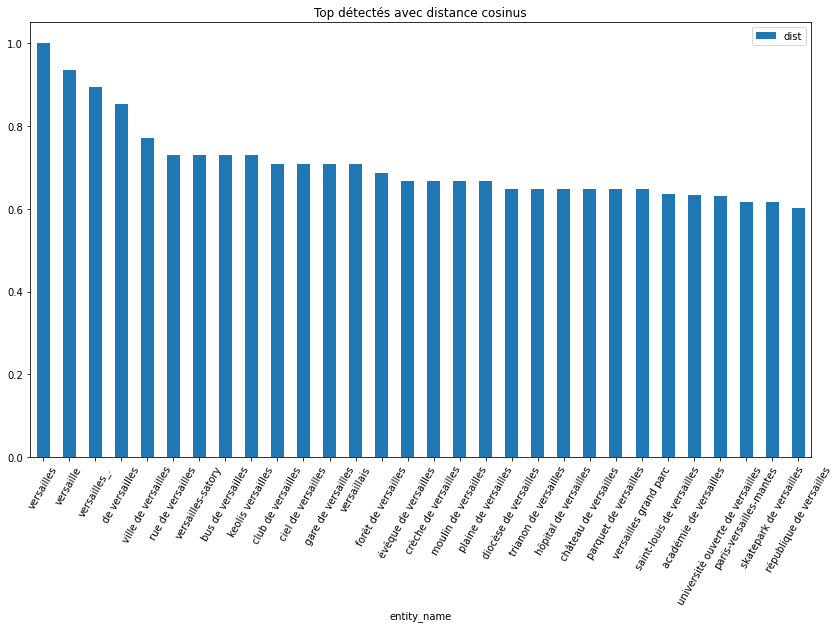

In [ ]:
versailles_cos = found.sort_values(ascending=False).to_frame(name='dist').assign(
                        entity_name = lambda D : entities_value_counts.index.to_series().reset_index(drop=True).loc[D.index]
).set_index('entity_name')

versailles_cos.head(30).plot(kind='bar',title='Top détectés avec distance cosinus',rot=60,figsize=(14,8))


In [ ]:
seuils = range(10,100,5)
min_mot_par_seuil = lambda D :  utils.pandas.DataFrame([ (D[D.dist>s/100].iloc[-1].name,s/100) for s in reversed(seuils)],columns=['name','seuil']).set_index('name')

In [ ]:
min_mot_par_seuil(versailles_cos).T

name,versailles,versaille,de versailles,de versailles,ville de versailles,versaillais,plaine de versailles,gare de versailles-chantiers,sûreté urbaine de versailles,université de versailles saint-quentin-en- yvelines,quartier richard-mique de versailles,béquilles,vernouillet,chelles,lycée jules-verne de sartrouville,rue des halles,place charles-de- gaulle,lycée villaroy
seuil,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1


###### résultats cohérents jusqu'à 45% de similarité

##### 2°) Calcul de similarité avec jaccard

In [ ]:
Sfinder            = search.Finder(Tx=towns_good_names[73])
found              = Sfinder.search(entities_names,nlp=False,dist=utils.jaccard_mat_vec)
versailles_jaccard = found.sort_values(ascending=False).to_frame(name='dist').assign(
       entity_name = lambda D : entities_value_counts.index.to_series().reset_index(drop=True).loc[D.index]

                    ).set_index('entity_name')

<AxesSubplot:title={'center':'Top détectés avec distance jaccard'}, xlabel='entity_name'>

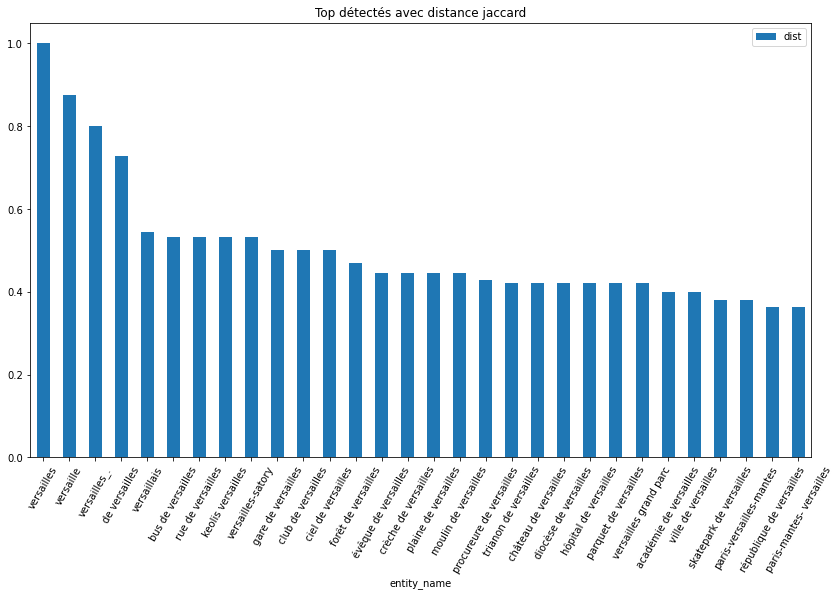

In [ ]:
versailles_jaccard.head(30).plot(kind='bar',title='Top détectés avec distance jaccard',rot=60,figsize=(14,8))

##### on remarque un recul des mots composés comme ville de versailles par rapport au cosinus

In [ ]:
min_mot_par_seuil(versailles_jaccard).T

name,versailles,versailles,versaille,versaille,versailles_.,de versailles,de versailles,de versailles,de versailles,versailles-satory,forêt de versailles,versailles grand parc,palais des congrès de versailles,sûreté urbaine de versailles,bailleur,versailles-saint-quentin-en-yvelines,marseille,vieille-eglise-en-yvelines
seuil,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1


###### résultats cohérents jusqu'à 30% de similarité

##### 3°) Choix du des entités selon seuil pondérés avec les deux distances

In [ ]:
versailles_moyenne = (utils.pandas.concat([versailles_cos,versailles_jaccard],axis=1).sum(axis=1)/2).to_frame(name='dist')
min_mot_par_seuil(versailles_moyenne).T

name,versailles,versaille,versaille,versailles_.,de versailles,de versailles,de versailles,versaillais,plaine de versailles,procureure de versailles,procureure de versailles,palais des congrès de versailles,houilles,rue des cailles,vernouillet,palais de houilles,ville d’achères,avenue de paris/avenue de l’europe
seuil,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1


###### résultats cohérents jusqu'à 40% de similarité

#### classification des termes contenant explicitement versaill

In [ ]:
M = versailles_moyenne.assign(y = versailles_moyenne.index.to_series().str.contains('versaill'))

In [ ]:
utils.pandas.crosstab(M.dist>.4,M.y)

y,False,True
dist,,
False,2309,6
True,1,43


In [ ]:
43./49

0.8775510204081632

##### le seuil de 40% permet d'avoir un tpr à 87.8%, voyons si la courbe de roc permet un meilleur choix de seuil

In [ ]:
score,y = M.dist,M.y+0

In [ ]:
roc = utils.pandas.DataFrame(utils.numpy.c_[roc_curve(y,score)],columns=['fpr','tpr','thresholds'])
(roc.tpr - roc.fpr).sort_values()

0      0.000000
119    0.000000
1      0.020408
2      0.081633
3      0.163265
         ...   
26     0.993939
25     0.995238
24     0.995671
23     0.996537
22     0.997835
Length: 120, dtype: float64

In [ ]:
roc.loc[22]

fpr           0.002165
tpr           1.000000
thresholds    0.316550
Name: 22, dtype: float64

In [ ]:
utils.pandas.crosstab(M.dist>0.316550,M.y)

y,False,True
dist,,
False,2305,0
True,5,49


##### le seuil de 31.655% permet d'inclure toutes les orthographes avec "versaill"

In [ ]:
M[M.dist>0.316550].index

Index(['versailles', 'versaille', 'versailles_.', 'de versailles',
       'ville de versailles', 'rue de versailles', 'versailles-satory',
       'bus de versailles', 'keolis versailles', 'club de versailles',
       'ciel de versailles', 'gare de versailles', 'versaillais',
       'forêt de versailles', 'évêque de versailles', 'crèche de versailles',
       'moulin de versailles', 'plaine de versailles', 'diocèse de versailles',
       'trianon de versailles', 'hôpital de versailles',
       'château de versailles', 'parquet de versailles',
       'versailles grand parc', 'saint-louis de versailles',
       'académie de versailles', 'université ouverte de versailles',
       'paris-versailles-mantes', 'skatepark de versailles',
       'république de versailles', 'paris-mantes- versailles',
       'patrimoine de versailles', 'gare de versailles-chantiers',
       'opéra royal de versailles', 'cour d’appel de versailles',
       'commissariat de versailles', 'procureure de versailles',


Compte tenu des résultats, nous rajoutons la contrainte qu'il faut que les 3 première lettre de la ville soit comprises dans l'expression

In [ ]:
def EntityRenamer(goodname,entities=entities_names,seuil=.31655):
    F = search.Finder(Tx=goodname)
    GetD = lambda D : F.search(entities,nlp=False,dist=D
                                    ).to_frame(name='dist').assign(
                           entity_name = lambda D : entities_value_counts.index.to_series().reset_index(drop=True).loc[D.index]
                    ).set_index('entity_name')

    cos,jaccard = GetD(D=utils.cos_mat_vec),GetD(D=utils.jaccard_mat_vec)
    moyenne     = (utils.pandas.concat([cos,jaccard],axis=1).sum(axis=1)/2).to_frame(name='dist').sort_values('dist',ascending=False)
    return moyenne[moyenne.dist>seuil].pipe(lambda M: M[M.index.to_series().str.contains(goodname[0])]).assign(n='_'.join(goodname)).n.to_dict()

In [ ]:
print(EntityRenamer(towns_good_names[73]))

{'versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'versaille': 'ver_ers_rsa_sai_ail_ill_lle_les', 'versailles_.': 'ver_ers_rsa_sai_ail_ill_lle_les', 'de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'versailles-satory': 'ver_ers_rsa_sai_ail_ill_lle_les', 'bus de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'keolis versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'rue de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'versaillais': 'ver_ers_rsa_sai_ail_ill_lle_les', 'club de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'gare de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'ciel de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'ville de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'forêt de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'plaine de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'crèche de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'moulin de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'évêque de versailles': 'ver_ers_rsa_sai_ail_ill_lle_les', 'c

### IV.2.2) Généralisation du calcul de similarité

In [ ]:
EntityRenamer(towns_good_names[22])

{'buchelay': 'buc_uch_che_hel_ela_lay',
 'rue de buchelay': 'buc_uch_che_hel_ela_lay',
 'bucheloise': 'buc_uch_che_hel_ela_lay',
 'closeaux de buchelay': 'buc_uch_che_hel_ela_lay'}

In [ ]:
RenameDict ={}
for town in utils.tqdm.tqdm(towns_good_names):
    RenameDict.update(EntityRenamer(town))

100%|█████████████████████████████████████████████████████████████| 262/262 [13:12<00:00,  3.03s/it]


In [ ]:
len(RenameDict)

582

### IV.2.2) Vérification avec les entités contenant explicitement les villes dans une séquence

In [ ]:
found = search.Finder(subs=[e.split() for e in entities_value_counts.index.to_series()]
                     ).search([seq.split() for seq in polygons.nom.str.lower().tolist()]

                             ).applymap(len).rename(polygons.nom.str.lower())



100%|████████████████████████████████████████████████████████████| 262/262 [00:01<00:00, 244.13it/s]


In [ ]:
RenameDictCont = dict(sum(found.T.apply(lambda c : [(i[0],'_'.join(to_triplet_list(c.name))) for i in c[c>0].index]).tolist(),[]))

In [ ]:
len(RenameDictCont)

172

In [ ]:
RenameDict.update(RenameDictCont)

In [ ]:
len(RenameDict)

582

##### apport null des séquences

### IV.3) Graph des co-citations au sein du département

In [ ]:
villes_in_docs = actu78[['ville']].merge(towns[['nom']].assign(ville=towns.given_address.str.strip()),how='left',on='ville').fillna('').nom.str.lower()
replace_name = utils.pandas.Series(polygons.nom.tolist(),index=map('_'.join,towns_good_names)).to_dict()

liens = utils.pandas.DataFrame([ (replace_name['_'.join(to_triplet_list(v))] ,replace_name[RenameDict[entity]] )
    for v,doc_entities in zip(villes_in_docs,entities)
    for entity in doc_entities
    if entity in RenameDict and '_'.join(to_triplet_list(v)) in replace_name
                                         ],columns=['source','target']
                              ).groupby(['source','target']).size().reset_index().rename(columns={0:'weight'})

In [ ]:
G = networkx.from_pandas_edgelist(liens,source='source',target='target',edge_attr='weight')
edges     = [('Ablis', 'Rambouillet'), ('Rambouillet', 'Auffargis'), ('Rambouillet', 'Beynes'), ('Rambouillet', "Bois-d'Arcy"), ('Rambouillet', 'Boissière-École'), ('Rambouillet', 'Cernay-la-Ville'), ('Rambouillet', 'Chevreuse'), ('Rambouillet', 'Clayes-sous-Bois'), ('Rambouillet', 'Essarts-le-Roi'), ('Rambouillet', 'Falaise'), ('Rambouillet', 'Fontenay-le-Fleury'), ('Rambouillet', 'Grosrouvre'), ('Rambouillet', 'Guyancourt'), ('Rambouillet', 'Houdan'), ('Rambouillet', 'Limay'), ('Rambouillet', 'Magny-les-Hameaux'), ('Rambouillet', 'Mantes-la-Jolie'), ('Rambouillet', 'Mesnuls'), ('Rambouillet', 'Mureaux'), ('Rambouillet', 'Noisy-le-Roi'), ('Rambouillet', 'Perray-en-Yvelines'), ('Rambouillet', 'Ponthévrard'), ('Rambouillet', 'Andelu'), ('Rambouillet', 'Blaru'), ('Rambouillet', 'Bonnelles'), ('Rambouillet', 'Celle-les-Bordes'), ('Rambouillet', 'Chesnay'), ('Rambouillet', 'Choisel'), ('Rambouillet', 'Châteaufort'), ('Rambouillet', 'Clairefontaine-en-Yvelines'), ('Rambouillet', 'Conflans-Sainte-Honorine'), ('Rambouillet', 'Ecquevilly'), ('Rambouillet', 'Gambais'), ('Rambouillet', 'Gambaiseuil'), ('Rambouillet', 'Gazeran'), ('Rambouillet', 'Gommecourt'), ('Rambouillet', 'Hermeray'), ('Rambouillet', 'Jouars-Pontchartrain'), ('Rambouillet', 'Magnanville'), ('Rambouillet', 'Maisons-Laffitte'), ('Rambouillet', 'Mantes-la-Ville'), ('Rambouillet', 'Millemont'), ('Rambouillet', "Montfort-l'Amaury"), ('Rambouillet', 'Montigny-le-Bretonneux'), ('Rambouillet', 'Neauphlette'), ('Rambouillet', 'Poigny-la-Forêt'), ('Rambouillet', 'Poissy'), ('Rambouillet', 'Prunay-en-Yvelines'), ('Rambouillet', 'Raizeux'), ('Rambouillet', 'Rambouillet'), ('Rambouillet', 'Rennemoulin'), ('Rambouillet', 'Saint-Arnoult-en-Yvelines'), ('Rambouillet', "Saint-Cyr-l'École"), ('Rambouillet', 'Saint-Léger-en-Yvelines'), ('Rambouillet', 'Septeuil'), ('Rambouillet', 'Sonchamp'), ('Rambouillet', 'Thoiry'), ('Rambouillet', 'Vernouillet'), ('Rambouillet', 'Versailles'), ('Rambouillet', 'Villeneuve-en-Chevrie'), ('Rambouillet', 'Villette'), ('Rambouillet', 'Viroflay'), ('Rambouillet', 'Émancé'), ('Rambouillet', 'Saint-Martin-de-Bréthencourt'), ('Rambouillet', 'Trappes'), ('Rambouillet', 'Villiers-Saint-Frédéric'), ('Rambouillet', 'Voisins-le-Bretonneux'), ('Achères', 'Achères'), ('Achères', 'Chesnay'), ('Achères', 'Conflans-Sainte-Honorine'), ('Achères', 'Aubergenville'), ('Achères', "Bois-d'Arcy"), ('Achères', 'Flins-sur-Seine'), ('Achères', 'Mureaux'), ('Achères', 'Poissy'), ('Achères', 'Verneuil-sur-Seine'), ('Chesnay', 'Beynes'), ('Chesnay', "Bois-d'Arcy"), ('Chesnay', 'Bougival'), ('Chesnay', 'Chatou'), ('Chesnay', 'Chesnay'), ('Chesnay', 'Maisons-Laffitte'), ('Chesnay', 'Marcq'), ('Chesnay', 'Noisy-le-Roi'), ('Chesnay', 'Poissy'), ('Chesnay', 'Rennemoulin'), ('Chesnay', 'Rocquencourt'), ('Chesnay', 'Saint-Lambert'), ('Chesnay', 'Saint-Nom-la-Bretèche'), ('Chesnay', 'Versailles'), ('Chesnay', 'Issou'), ('Chesnay', 'Trappes'), ('Chesnay', 'Verneuil-sur-Seine'), ('Conflans-Sainte-Honorine', 'Andrésy'), ('Conflans-Sainte-Honorine', 'Boissière-École'), ('Conflans-Sainte-Honorine', 'Cernay-la-Ville'), ('Conflans-Sainte-Honorine', "Bois-d'Arcy"), ('Conflans-Sainte-Honorine', 'Chanteloup-les-Vignes'), ('Conflans-Sainte-Honorine', 'Conflans-Sainte-Honorine'), ('Conflans-Sainte-Honorine', 'Issou'), ('Conflans-Sainte-Honorine', 'Maisons-Laffitte'), ('Conflans-Sainte-Honorine', 'Mantes-la-Jolie'), ('Conflans-Sainte-Honorine', 'Poissy'), ('Conflans-Sainte-Honorine', 'Saint-Germain-en-Laye'), ('Conflans-Sainte-Honorine', 'Triel-sur-Seine'), ('Conflans-Sainte-Honorine', 'Versailles'), ('Conflans-Sainte-Honorine', 'Mesnil-Saint-Denis'), ('Conflans-Sainte-Honorine', 'Plaisir'), ('Conflans-Sainte-Honorine', 'Villennes-sur-Seine'), ('Conflans-Sainte-Honorine', 'Voisins-le-Bretonneux'), ('Adainville', 'Adainville'), ('Adainville', 'Poigny-la-Forêt'), ('Adainville', 'Versailles'), ('Versailles', 'Andrésy'), ('Versailles', 'Aubergenville'), ('Versailles', 'Auffargis'), ('Versailles', 'Autouillet'), ('Versailles', 'Bazemont'), ('Versailles', "Bois-d'Arcy"), ('Versailles', 'Bougival'), ('Versailles', 'Buc'), ('Versailles', 'Buchelay'), ('Versailles', 'Carrières-sous-Poissy'), ('Versailles', 'Celle-Saint-Cloud'), ('Versailles', 'Cernay-la-Ville'), ('Versailles', 'Chambourcy'), ('Versailles', 'Chanteloup-les-Vignes'), ('Versailles', 'Chatou'), ('Versailles', 'Coignières'), ('Versailles', 'Dampierre-en-Yvelines'), ('Versailles', 'Falaise'), ('Versailles', 'Fontenay-le-Fleury'), ('Versailles', 'Freneuse'), ('Versailles', 'Gaillon-sur-Montcient'), ('Versailles', 'Gargenville'), ('Versailles', 'Guyancourt'), ('Versailles', 'Hardricourt'), ('Versailles', 'Houilles'), ('Versailles', 'Jouars-Pontchartrain'), ('Versailles', 'Jouy-en-Josas'), ('Versailles', 'Limay'), ('Versailles', 'Loges-en-Josas'), ('Versailles', 'Magnanville'), ('Versailles', 'Magny-les-Hameaux'), ('Versailles', 'Maisons-Laffitte'), ('Versailles', 'Mantes-la-Jolie'), ('Versailles', 'Mantes-la-Ville'), ('Versailles', 'Maurepas'), ('Versailles', 'Meulan-en-Yvelines'), ('Versailles', 'Montigny-le-Bretonneux'), ('Versailles', 'Mousseaux-sur-Seine'), ('Versailles', 'Mureaux'), ('Versailles', 'Mézières-sur-Seine'), ('Versailles', 'Noisy-le-Roi'), ('Versailles', 'Orgeval'), ('Versailles', 'Pecq'), ('Versailles', 'Perray-en-Yvelines'), ('Versailles', 'Plaisir'), ('Versailles', 'Poissy'), ('Versailles', 'Ponthévrard'), ('Versailles', 'Porcheville'), ('Versailles', 'Port-Marly'), ('Versailles', 'Queue-les-Yvelines'), ('Versailles', 'Rosny-sur-Seine'), ('Versailles', 'Saint-Germain-en-Laye'), ('Versailles', 'Saint-Léger-en-Yvelines'), ('Versailles', 'Saint-Martin-de-Bréthencourt'), ('Versailles', 'Saint-Rémy-lès-Chevreuse'), ('Versailles', 'Sartrouville'), ('Versailles', 'Tessancourt-sur-Aubette'), ('Versailles', 'Thoiry'), ('Versailles', 'Trappes'), ('Versailles', 'Vaux-sur-Seine'), ('Versailles', 'Verrière'), ('Versailles', 'Aulnay-sur-Mauldre'), ('Versailles', 'Boissy-sans-Avoir'), ('Versailles', 'Bonnières-sur-Seine'), ('Versailles', 'Bouafle'), ('Versailles', 'Celle-les-Bordes'), ('Versailles', 'Châteaufort'), ('Versailles', 'Clairefontaine-en-Yvelines'), ('Versailles', 'Clayes-sous-Bois'), ('Versailles', 'Galluis'), ('Versailles', 'Hermeray'), ('Versailles', 'Marly-le-Roi'), ('Versailles', 'Rocquencourt'), ('Versailles', "Saint-Cyr-l'École"), ('Versailles', 'Saint-Lambert'), ('Versailles', 'Tilly'), ('Versailles', 'Versailles'), ('Versailles', 'Vicq'), ('Versailles', 'Villette'), ('Versailles', 'Viroflay'), ('Versailles', 'Vélizy-Villacoublay'), ('Versailles', 'Vésinet'), ('Versailles', 'Villepreux'), ('Versailles', 'Villiers-Saint-Frédéric'), ('Versailles', 'Voisins-le-Bretonneux'), ('Versailles', 'Élancourt'), ('Versailles', 'Épône'), ('Andrésy', 'Andrésy'), ('Andrésy', 'Mantes-la-Ville'), ('Andrésy', 'Tilly'), ('Andrésy', 'Bazemont'), ('Andrésy', 'Chanteloup-les-Vignes'), ('Andrésy', 'Guyancourt'), ('Mantes-la-Ville', 'Aubergenville'), ('Mantes-la-Ville', 'Chambourcy'), ('Mantes-la-Ville', 'Flins-sur-Seine'), ('Mantes-la-Ville', 'Fontenay-Saint-Père'), ('Mantes-la-Ville', 'Freneuse'), ('Mantes-la-Ville', 'Guyancourt'), ('Mantes-la-Ville', 'Limay'), ('Mantes-la-Ville', 'Magnanville'), ('Mantes-la-Ville', 'Mantes-la-Jolie'), ('Mantes-la-Ville', 'Bonnières-sur-Seine'), ('Mantes-la-Ville', 'Buchelay'), ('Mantes-la-Ville', 'Gargenville'), ('Mantes-la-Ville', 'Guerville'), ('Mantes-la-Ville', 'Houdan'), ('Mantes-la-Ville', 'Mantes-la-Ville'), ('Mantes-la-Ville', 'Poissy'), ('Mantes-la-Ville', 'Maule'), ('Mantes-la-Ville', 'Mureaux'), ('Mantes-la-Ville', 'Mézières-sur-Seine'), ('Mantes-la-Ville', 'Porcheville'), ('Mantes-la-Ville', 'Trappes'), ('Mantes-la-Ville', 'Villeneuve-en-Chevrie'), ('Tilly', 'Poissy'), ('Tilly', 'Trappes'), ('Tilly', 'Épône'), ('Aubergenville', 'Andelu'), ('Aubergenville', 'Aubergenville'), ('Aubergenville', 'Aulnay-sur-Mauldre'), ('Aubergenville', "Bois-d'Arcy"), ('Aubergenville', 'Carrières-sous-Poissy'), ('Aubergenville', 'Chatou'), ('Aubergenville', 'Gargenville'), ('Aubergenville', 'Limay'), ('Aubergenville', 'Mantes-la-Jolie'), ('Aubergenville', 'Meulan-en-Yvelines'), ('Aubergenville', 'Montigny-le-Bretonneux'), ('Aubergenville', 'Mureaux'), ('Aubergenville', 'Mézières-sur-Seine'), ('Aubergenville', 'Orgeval'), ('Aubergenville', 'Poissy'), ('Aubergenville', 'Triel-sur-Seine'), ('Aubergenville', 'Épône'), ('Aubergenville', 'Évecquemont'), ('Aubergenville', 'Bazemont'), ('Aubergenville', 'Chambourcy'), ('Aubergenville', 'Guyancourt'), ('Aubergenville', 'Sartrouville'), ('Andelu', 'Gargenville'), ('Andelu', 'Montigny-le-Bretonneux'), ('Andelu', 'Plaisir'), ('Andelu', 'Verneuil-sur-Seine'), ('Aulnay-sur-Mauldre', 'Mantes-la-Jolie'), ("Bois-d'Arcy", 'Beynes'), ("Bois-d'Arcy", "Bois-d'Arcy"), ("Bois-d'Arcy", 'Carrières-sous-Poissy'), ("Bois-d'Arcy", 'Chanteloup-les-Vignes'), ("Bois-d'Arcy", 'Houdan'), ("Bois-d'Arcy", "Saint-Cyr-l'École"), ("Bois-d'Arcy", 'Bougival'), ("Bois-d'Arcy", 'Buc'), ("Bois-d'Arcy", 'Clayes-sous-Bois'), ("Bois-d'Arcy", 'Fontenay-le-Fleury'), ("Bois-d'Arcy", 'Gaillon-sur-Montcient'), ("Bois-d'Arcy", 'Guyancourt'), ("Bois-d'Arcy", 'Jouy-en-Josas'), ("Bois-d'Arcy", 'Louveciennes'), ("Bois-d'Arcy", 'Maisons-Laffitte'), ("Bois-d'Arcy", 'Montigny-le-Bretonneux'), ("Bois-d'Arcy", 'Mureaux'), ("Bois-d'Arcy", 'Plaisir'), ("Bois-d'Arcy", 'Saint-Arnoult-en-Yvelines'), ("Bois-d'Arcy", 'Saint-Rémy-lès-Chevreuse'), ("Bois-d'Arcy", 'Thoiry'), ("Bois-d'Arcy", 'Trappes'), ("Bois-d'Arcy", 'Villepreux'), ("Bois-d'Arcy", 'Voisins-le-Bretonneux'), ("Bois-d'Arcy", 'Élancourt'), ('Carrières-sous-Poissy', 'Beynes'), ('Carrières-sous-Poissy', 'Carrières-sous-Poissy'), ('Carrières-sous-Poissy', 'Carrières-sur-Seine'), ('Carrières-sous-Poissy', 'Ecquevilly'), ('Carrières-sous-Poissy', 'Mureaux'), ('Carrières-sous-Poissy', 'Poissy'), ('Carrières-sous-Poissy', 'Rennemoulin'), ('Carrières-sous-Poissy', 'Triel-sur-Seine'), ('Carrières-sous-Poissy', 'Verneuil-sur-Seine'), ('Carrières-sous-Poissy', 'Chanteloup-les-Vignes'), ('Carrières-sous-Poissy', 'Port-Marly'), ('Carrières-sous-Poissy', 'Trappes'), ('Carrières-sous-Poissy', 'Voisins-le-Bretonneux'), ('Chatou', 'Bougival'), ('Chatou', 'Chatou'), ('Chatou', 'Saint-Germain-en-Laye'), ('Chatou', 'Sartrouville'), ('Chatou', 'Vésinet'), ('Chatou', 'Houilles'), ('Chatou', 'Limay'), ('Chatou', 'Mantes-la-Jolie'), ('Chatou', 'Montesson'), ('Chatou', 'Mureaux'), ('Chatou', 'Trappes'), ('Chatou', 'Villiers-Saint-Frédéric'), ('Chatou', 'Élancourt'), ('Gargenville', 'Bouafle'), ('Gargenville', 'Gargenville'), ('Gargenville', 'Limay'), ('Gargenville', 'Mantes-la-Jolie'), ('Gargenville', 'Mureaux'), ('Gargenville', 'Senlisse'), ('Gargenville', 'Vaux-sur-Seine'), ('Gargenville', 'Juziers'), ('Gargenville', 'Mézières-sur-Seine'), ('Gargenville', 'Épône'), ('Limay', 'Breuil-Bois-Robert'), ('Limay', 'Gaillon-sur-Montcient'), ('Limay', 'Croissy-sur-Seine'), ('Limay', 'Flins-sur-Seine'), ('Limay', 'Limay'), ('Limay', 'Maisons-Laffitte'), ('Limay', 'Mantes-la-Jolie'), ('Limay', 'Montigny-le-Bretonneux'), ('Limay', 'Poissy'), ('Limay', 'Saint-Germain-en-Laye'), ('Limay', 'Triel-sur-Seine'), ('Limay', 'Verrière'), ('Limay', 'Mureaux'), ('Limay', 'Trappes'), ('Mantes-la-Jolie', 'Bennecourt'), ('Mantes-la-Jolie', 'Blaru'), ('Mantes-la-Jolie', 'Bonnières-sur-Seine'), ('Mantes-la-Jolie', 'Buc'), ('Mantes-la-Jolie', 'Buchelay'), ('Mantes-la-Jolie', 'Clayes-sous-Bois'), ('Mantes-la-Jolie', 'Gaillon-sur-Montcient'), ('Mantes-la-Jolie', 'Guyancourt'), ('Mantes-la-Jolie', 'Houdan'), ('Mantes-la-Jolie', 'Issou'), ('Mantes-la-Jolie', 'Magnanville'), ('Mantes-la-Jolie', 'Maisons-Laffitte'), ('Mantes-la-Jolie', 'Bailly'), ('Mantes-la-Jolie', 'Bouafle'), ('Mantes-la-Jolie', 'Bréval'), ('Mantes-la-Jolie', 'Châteaufort'), ('Mantes-la-Jolie', 'Drocourt'), ('Mantes-la-Jolie', 'Ecquevilly'), ('Mantes-la-Jolie', 'Follainville-Dennemont'), ('Mantes-la-Jolie', 'Fontenay-Mauvoisin'), ('Mantes-la-Jolie', 'Freneuse'), ('Mantes-la-Jolie', 'Juziers'), ('Mantes-la-Jolie', 'Longnes'), ('Mantes-la-Jolie', 'Mantes-la-Jolie'), ('Mantes-la-Jolie', 'Mareil-Marly'), ('Mantes-la-Jolie', 'Marly-le-Roi'), ('Mantes-la-Jolie', 'Maule'), ('Mantes-la-Jolie', 'Meulan-en-Yvelines'), ('Mantes-la-Jolie', 'Moisson'), ('Mantes-la-Jolie', 'Mureaux'), ('Mantes-la-Jolie', 'Mézières-sur-Seine'), ('Mantes-la-Jolie', 'Oinville-sur-Montcient'), ('Mantes-la-Jolie', 'Poissy'), ('Mantes-la-Jolie', 'Rosay'), ('Mantes-la-Jolie', 'Rosny-sur-Seine'), ('Mantes-la-Jolie', "Saint-Cyr-l'École"), ('Mantes-la-Jolie', 'Saint-Germain-en-Laye'), ('Mantes-la-Jolie', 'Saint-Illiers-le-Bois'), ('Mantes-la-Jolie', 'Saint-Martin-la-Garenne'), ('Mantes-la-Jolie', 'Tessancourt-sur-Aubette'), ('Mantes-la-Jolie', 'Verneuil-sur-Seine'), ('Mantes-la-Jolie', 'Vernouillet'), ('Mantes-la-Jolie', 'Vert'), ('Mantes-la-Jolie', 'Villette'), ('Mantes-la-Jolie', 'Vélizy-Villacoublay'), ('Mantes-la-Jolie', 'Vésinet'), ('Mantes-la-Jolie', 'Épône'), ('Mantes-la-Jolie', 'Étang-la-Ville'), ('Mantes-la-Jolie', 'Porcheville'), ('Mantes-la-Jolie', 'Queue-les-Yvelines'), ('Mantes-la-Jolie', 'Saint-Arnoult-en-Yvelines'), ('Mantes-la-Jolie', 'Sartrouville'), ('Mantes-la-Jolie', 'Trappes'), ('Mantes-la-Jolie', 'Villeneuve-en-Chevrie'), ('Meulan-en-Yvelines', 'Chambourcy'), ('Meulan-en-Yvelines', 'Flins-sur-Seine'), ('Meulan-en-Yvelines', 'Juziers'), ('Meulan-en-Yvelines', 'Hardricourt'), ('Meulan-en-Yvelines', 'Meulan-en-Yvelines'), ('Meulan-en-Yvelines', 'Mureaux'), ('Meulan-en-Yvelines', 'Mézières-sur-Seine'), ('Meulan-en-Yvelines', 'Mézy-sur-Seine'), ('Meulan-en-Yvelines', 'Saint-Lambert'), ('Meulan-en-Yvelines', 'Tessancourt-sur-Aubette'), ('Meulan-en-Yvelines', 'Triel-sur-Seine'), ('Meulan-en-Yvelines', 'Vaux-sur-Seine'), ('Meulan-en-Yvelines', 'Épône'), ('Meulan-en-Yvelines', 'Évecquemont'), ('Meulan-en-Yvelines', 'Saint-Germain-en-Laye'), ('Montigny-le-Bretonneux', 'Clayes-sous-Bois'), ('Montigny-le-Bretonneux', 'Flins-sur-Seine'), ('Montigny-le-Bretonneux', 'Gaillon-sur-Montcient'), ('Montigny-le-Bretonneux', 'Guyancourt'), ('Montigny-le-Bretonneux', 'Maule'), ('Montigny-le-Bretonneux', 'Mesnil-Saint-Denis'), ('Montigny-le-Bretonneux', 'Montigny-le-Bretonneux'), ('Montigny-le-Bretonneux', 'Noisy-le-Roi'), ('Montigny-le-Bretonneux', 'Saint-Lambert'), ('Montigny-le-Bretonneux', 'Saint-Léger-en-Yvelines'), ('Montigny-le-Bretonneux', 'Saint-Martin-de-Bréthencourt'), ('Montigny-le-Bretonneux', 'Trappes'), ('Montigny-le-Bretonneux', 'Verrière'), ('Montigny-le-Bretonneux', 'Vert'), ('Montigny-le-Bretonneux', 'Voisins-le-Bretonneux'), ('Montigny-le-Bretonneux', 'Plaisir'), ('Montigny-le-Bretonneux', 'Poissy'), ('Mureaux', 'Chambourcy'), ('Mureaux', 'Flins-sur-Seine'), ('Mureaux', 'Autouillet'), ('Mureaux', 'Bonnières-sur-Seine'), ('Mureaux', 'Chanteloup-les-Vignes'), ('Mureaux', 'Ecquevilly'), ('Mureaux', 'Fontenay-le-Fleury'), ('Mureaux', 'Gaillon-sur-Montcient'), ('Mureaux', 'Maisons-Laffitte'), ('Mureaux', 'Maule'), ('Mureaux', 'Mureaux'), ('Mureaux', 'Poissy'), ('Mureaux', "Saint-Cyr-l'École"), ('Mureaux', 'Saint-Germain-de-la-Grange'), ('Mureaux', 'Saint-Germain-en-Laye'), ('Mureaux', 'Saint-Léger-en-Yvelines'), ('Mureaux', "Saint-Rémy-l'Honoré"), ('Mureaux', 'Sartrouville'), ('Mureaux', 'Trappes'), ('Mureaux', 'Vaux-sur-Seine'), ('Mureaux', 'Verneuil-sur-Seine'), ('Mureaux', 'Vernouillet'), ('Mureaux', 'Vert'), ('Mureaux', 'Villette'), ('Mureaux', 'Vélizy-Villacoublay'), ('Mureaux', 'Élancourt'), ('Mureaux', 'Épône'), ('Mureaux', 'Mézières-sur-Seine'), ('Mureaux', 'Mézy-sur-Seine'), ('Mureaux', 'Tessancourt-sur-Aubette'), ('Mureaux', 'Villiers-Saint-Frédéric'), ('Mureaux', 'Évecquemont'), ('Mézières-sur-Seine', 'Guerville'), ('Mézières-sur-Seine', 'Chanteloup-les-Vignes'), ('Mézières-sur-Seine', 'Mézières-sur-Seine'), ('Mézières-sur-Seine', 'Épône'), ('Mézières-sur-Seine', 'Poissy'), ('Mézières-sur-Seine', 'Villennes-sur-Seine'), ('Orgeval', 'Clayes-sous-Bois'), ('Orgeval', 'Feucherolles'), ('Orgeval', 'Orgeval'), ('Orgeval', 'Poissy'), ('Orgeval', 'Villepreux'), ('Orgeval', 'Saint-Germain-en-Laye'), ('Poissy', 'Chanteloup-les-Vignes'), ('Poissy', 'Croissy-sur-Seine'), ('Poissy', 'Guerville'), ('Poissy', 'Maisons-Laffitte'), ('Poissy', 'Mareil-sur-Mauldre'), ('Poissy', 'Maule'), ('Poissy', 'Plaisir'), ('Poissy', 'Aigremont'), ('Poissy', 'Auteuil'), ('Poissy', 'Buchelay'), ('Poissy', 'Chambourcy'), ('Poissy', 'Davron'), ('Poissy', 'Feucherolles'), ('Poissy', 'Grandchamp'), ('Poissy', 'Marcq'), ('Poissy', 'Marly-le-Roi'), ('Poissy', 'Morainvilliers'), ('Poissy', 'Poissy'), ('Poissy', 'Saint-Germain-en-Laye'), ('Poissy', 'Saint-Hilarion'), ('Poissy', 'Saint-Lambert'), ('Poissy', 'Sartrouville'), ('Poissy', 'Triel-sur-Seine'), ('Poissy', 'Verneuil-sur-Seine'), ('Poissy', 'Villennes-sur-Seine'), ('Poissy', 'Villiers-le-Mahieu'), ('Poissy', 'Viroflay'), ('Poissy', 'Vélizy-Villacoublay'), ('Poissy', 'Thoiry'), ('Poissy', 'Trappes'), ('Poissy', 'Vésinet'), ('Triel-sur-Seine', 'Chanteloup-les-Vignes'), ('Triel-sur-Seine', 'Triel-sur-Seine'), ('Triel-sur-Seine', 'Vernouillet'), ('Triel-sur-Seine', 'Villennes-sur-Seine'), ('Triel-sur-Seine', 'Verrière'), ('Épône', 'Magnanville'), ('Épône', 'Porcheville'), ('Épône', 'Flins-sur-Seine'), ('Épône', 'Verneuil-sur-Seine'), ('Épône', 'Épône'), ('Évecquemont', 'Tartre-Gaudran'), ('Évecquemont', 'Vaux-sur-Seine'), ('Évecquemont', 'Évecquemont'), ('Auffargis', 'Auffargis'), ('Auffargis', 'Fourqueux'), ('Fourqueux', 'Saint-Germain-en-Laye'), ('Autouillet', 'Autouillet'), ('Autouillet', 'Toussus-le-Noble'), ('Bazainville', 'Bazainville'), ('Bazainville', 'Houdan'), ('Houdan', 'Condé-sur-Vesgre'), ('Houdan', 'Gressey'), ('Houdan', 'Houdan'), ('Houdan', 'Neauphle-le-Château'), ('Houdan', 'Queue-les-Yvelines'), ('Bazemont', 'Bazemont'), ('Bazoches-sur-Guyonne', 'Bazoches-sur-Guyonne'), ('Bazoches-sur-Guyonne', 'Chevreuse'), ('Bennecourt', 'Bennecourt'), ('Beynes', 'Beynes'), ('Beynes', 'Jouars-Pontchartrain'), ('Beynes', 'Mareil-sur-Mauldre'), ('Beynes', 'Rennemoulin'), ('Beynes', 'Saint-Germain-en-Laye'), ('Beynes', 'Saint-Lambert'), ('Beynes', 'Sartrouville'), ('Beynes', 'Trappes'), ('Beynes', 'Villette'), ('Beynes', 'Neauphle-le-Château'), ('Beynes', 'Perray-en-Yvelines'), ('Jouars-Pontchartrain', 'Coignières'), ('Jouars-Pontchartrain', 'Jouars-Pontchartrain'), ('Jouars-Pontchartrain', 'Maisons-Laffitte'), ('Jouars-Pontchartrain', 'Maurepas'), ('Jouars-Pontchartrain', 'Neauphle-le-Château'), ('Jouars-Pontchartrain', 'Villiers-Saint-Frédéric'), ('Mareil-sur-Mauldre', 'Mareil-sur-Mauldre'), ('Rennemoulin', 'Chanteloup-les-Vignes'), ('Rennemoulin', 'Maurepas'), ('Rennemoulin', 'Saint-Arnoult-en-Yvelines'), ('Rennemoulin', 'Verneuil-sur-Seine'), ('Saint-Germain-en-Laye', 'Buc'), ('Saint-Germain-en-Laye', 'Carrières-sur-Seine'), ('Saint-Germain-en-Laye', 'Chambourcy'), ('Saint-Germain-en-Laye', 'Coignières'), ('Saint-Germain-en-Laye', 'Croissy-sur-Seine'), ('Saint-Germain-en-Laye', 'Maisons-Laffitte'), ('Saint-Germain-en-Laye', 'Pecq'), ('Saint-Germain-en-Laye', 'Port-Marly'), ('Saint-Germain-en-Laye', 'Châteaufort'), ('Saint-Germain-en-Laye', 'Ecquevilly'), ('Saint-Germain-en-Laye', 'Mareil-Marly'), ('Saint-Germain-en-Laye', 'Marly-le-Roi'), ('Saint-Germain-en-Laye', 'Neauphlette'), ('Saint-Germain-en-Laye', "Saint-Cyr-l'École"), ('Saint-Germain-en-Laye', 'Saint-Germain-en-Laye'), ('Saint-Germain-en-Laye', 'Saint-Lambert'), ('Saint-Germain-en-Laye', 'Thoiry'), ('Saint-Germain-en-Laye', 'Vernouillet'), ('Saint-Germain-en-Laye', 'Villiers-le-Mahieu'), ('Saint-Germain-en-Laye', 'Vésinet'), ('Saint-Germain-en-Laye', 'Sartrouville'), ('Saint-Germain-en-Laye', 'Trappes'), ('Saint-Germain-en-Laye', 'Villiers-Saint-Frédéric'), ('Saint-Lambert', 'Chambourcy'), ('Saint-Lambert', 'Clayes-sous-Bois'), ('Saint-Lambert', 'Plaisir'), ('Saint-Lambert', 'Chevreuse'), ('Saint-Lambert', 'Saint-Lambert'), ('Saint-Lambert', 'Sartrouville'), ('Saint-Lambert', 'Villennes-sur-Seine'), ('Sartrouville', 'Houilles'), ('Sartrouville', 'Maisons-Laffitte'), ('Sartrouville', 'Montesson'), ('Sartrouville', 'Pecq'), ('Sartrouville', 'Prunay-en-Yvelines'), ('Sartrouville', 'Saint-Martin-de-Bréthencourt'), ('Sartrouville', 'Sartrouville'), ('Sartrouville', 'Villette'), ('Sartrouville', 'Villiers-Saint-Frédéric'), ('Sartrouville', 'Voisins-le-Bretonneux'), ('Sartrouville', 'Trappes'), ('Trappes', 'Chanteloup-les-Vignes'), ('Trappes', 'Guyancourt'), ('Trappes', 'Plaisir'), ('Trappes', 'Celle-les-Bordes'), ('Trappes', 'Coignières'), ('Trappes', 'Magny-les-Hameaux'), ('Trappes', 'Maisons-Laffitte'), ('Trappes', 'Mesnil-Saint-Denis'), ('Trappes', 'Neauphlette'), ('Trappes', "Saint-Cyr-l'École"), ('Trappes', 'Saint-Léger-en-Yvelines'), ('Trappes', 'Sonchamp'), ('Trappes', 'Trappes'), ('Trappes', 'Verrière'), ('Trappes', 'Villepreux'), ('Trappes', 'Voisins-le-Bretonneux'), ('Trappes', 'Élancourt'), ('Villette', 'Plaisir'), ('Blaru', 'Chaufour-lès-Bonnières'), ('Blaru', 'Vernouillet'), ('Vernouillet', 'Port-Villez'), ('Vernouillet', 'Verneuil-sur-Seine'), ('Vernouillet', 'Bonnières-sur-Seine'), ('Vernouillet', 'Vernouillet'), ('Vernouillet', 'Vésinet'), ('Vernouillet', 'Villennes-sur-Seine'), ('Chanteloup-les-Vignes', 'Chanteloup-les-Vignes'), ('Chanteloup-les-Vignes', 'Maurecourt'), ('Chanteloup-les-Vignes', 'Voisins-le-Bretonneux'), ("Saint-Cyr-l'École", 'Celle-Saint-Cloud'), ("Saint-Cyr-l'École", 'Clayes-sous-Bois'), ("Saint-Cyr-l'École", 'Fontenay-le-Fleury'), ("Saint-Cyr-l'École", 'Guyancourt'), ("Saint-Cyr-l'École", 'Magny-les-Hameaux'), ("Saint-Cyr-l'École", 'Vélizy-Villacoublay'), ("Saint-Cyr-l'École", 'Élancourt'), ('Boissière-École', 'Boissière-École'), ('Bonnelles', 'Bonnelles'), ('Bonnelles', 'Saint-Léger-en-Yvelines'), ('Bonnelles', 'Port-Marly'), ('Saint-Léger-en-Yvelines', 'Clayes-sous-Bois'), ('Saint-Léger-en-Yvelines', 'Flins-sur-Seine'), ('Saint-Léger-en-Yvelines', 'Guyancourt'), ('Saint-Léger-en-Yvelines', 'Queue-les-Yvelines'), ('Saint-Léger-en-Yvelines', 'Saint-Léger-en-Yvelines'), ('Saint-Léger-en-Yvelines', 'Thoiry'), ('Saint-Léger-en-Yvelines', 'Verrière'), ('Saint-Léger-en-Yvelines', 'Villepreux'), ('Saint-Léger-en-Yvelines', 'Voisins-le-Bretonneux'), ('Bonnières-sur-Seine', 'Bonnières-sur-Seine'), ('Bonnières-sur-Seine', 'Mézy-sur-Seine'), ('Bonnières-sur-Seine', 'Rolleboise'), ('Bonnières-sur-Seine', 'Mousseaux-sur-Seine'), ('Bonnières-sur-Seine', 'Port-Villez'), ('Bonnières-sur-Seine', 'Saint-Arnoult-en-Yvelines'), ('Mézy-sur-Seine', 'Juziers'), ('Mézy-sur-Seine', 'Maurecourt'), ('Mézy-sur-Seine', 'Mézy-sur-Seine'), ('Bouafle', 'Bouafle'), ('Bouafle', 'Flins-sur-Seine'), ('Bougival', 'Bougival'), ('Bougival', 'Croissy-sur-Seine'), ('Bougival', 'Voisins-le-Bretonneux'), ('Bougival', 'Plaisir'), ('Croissy-sur-Seine', 'Carrières-sur-Seine'), ('Croissy-sur-Seine', 'Croissy-sur-Seine'), ('Croissy-sur-Seine', 'Marly-le-Roi'), ('Croissy-sur-Seine', 'Montesson'), ('Voisins-le-Bretonneux', 'Chapet'), ('Voisins-le-Bretonneux', 'Condé-sur-Vesgre'), ('Voisins-le-Bretonneux', 'Guyancourt'), ('Voisins-le-Bretonneux', 'Hardricourt'), ('Voisins-le-Bretonneux', 'Porcheville'), ('Voisins-le-Bretonneux', 'Villepreux'), ('Voisins-le-Bretonneux', 'Carrières-sur-Seine'), ('Voisins-le-Bretonneux', 'Jouy-en-Josas'), ('Voisins-le-Bretonneux', 'Magny-les-Hameaux'), ('Voisins-le-Bretonneux', 'Viroflay'), ('Voisins-le-Bretonneux', 'Voisins-le-Bretonneux'), ('Voisins-le-Bretonneux', 'Vélizy-Villacoublay'), ('Breuil-Bois-Robert', 'Breuil-Bois-Robert'), ('Brueil-en-Vexin', 'Guitrancourt'), ('Brueil-en-Vexin', 'Sailly'), ('Brueil-en-Vexin', 'Maule'), ('Guitrancourt', 'Issou'), ('Buc', 'Buc'), ('Buc', 'Châteaufort'), ('Buc', 'Guyancourt'), ('Buc', 'Saint-Forget'), ('Buc', 'Loges-en-Josas'), ('Châteaufort', 'Châteaufort'), ('Châteaufort', 'Plaisir'), ('Guyancourt', 'Buchelay'), ('Guyancourt', 'Clayes-sous-Bois'), ('Guyancourt', 'Bailly'), ('Guyancourt', 'Guyancourt'), ('Guyancourt', 'Magny-les-Hameaux'), ('Guyancourt', 'Plaisir'), ('Guyancourt', 'Saint-Rémy-lès-Chevreuse'), ('Guyancourt', 'Vélizy-Villacoublay'), ('Guyancourt', 'Élancourt'), ('Saint-Forget', 'Chambourcy'), ('Saint-Forget', 'Sonchamp'), ('Buchelay', 'Buchelay'), ('Buchelay', 'Rosny-sur-Seine'), ('Buchelay', 'Guerville'), ('Buchelay', 'Villeneuve-en-Chevrie'), ('Rosny-sur-Seine', 'Rosny-sur-Seine'), ('Bullion', 'Chevreuse'), ('Chevreuse', 'Cernay-la-Ville'), ('Chevreuse', 'Celle-les-Bordes'), ('Chevreuse', 'Chevreuse'), ('Chevreuse', 'Grosrouvre'), ('Chevreuse', 'Hermeray'), ('Chevreuse', 'Magny-les-Hameaux'), ('Chevreuse', "Saint-Rémy-l'Honoré"), ('Chevreuse', 'Lévis-Saint-Nom'), ('Chevreuse', 'Plaisir'), ('Carrières-sur-Seine', 'Carrières-sur-Seine'), ('Carrières-sur-Seine', 'Flins-sur-Seine'), ('Carrières-sur-Seine', 'Houilles'), ('Carrières-sur-Seine', 'Montesson'), ('Ecquevilly', 'Ecquevilly'), ('Verneuil-sur-Seine', 'Verneuil-sur-Seine'), ('Verneuil-sur-Seine', 'Villennes-sur-Seine'), ('Celle-Saint-Cloud', 'Celle-Saint-Cloud'), ('Cernay-la-Ville', 'Cernay-la-Ville'), ('Cernay-la-Ville', 'Dampierre-en-Yvelines'), ('Cernay-la-Ville', "Saint-Rémy-l'Honoré"), ('Cernay-la-Ville', 'Saint-Rémy-lès-Chevreuse'), ('Cernay-la-Ville', 'Coignières'), ('Dampierre-en-Yvelines', 'Dampierre-en-Yvelines'), ('Dampierre-en-Yvelines', 'Élancourt'), ('Dampierre-en-Yvelines', 'Saint-Arnoult-en-Yvelines'), ("Saint-Rémy-l'Honoré", 'Coignières'), ("Saint-Rémy-l'Honoré", 'Saint-Rémy-lès-Chevreuse'), ('Saint-Rémy-lès-Chevreuse', 'Saint-Rémy-lès-Chevreuse'), ('Chambourcy', 'Chambourcy'), ('Chambourcy', 'Hardricourt'), ('Hardricourt', 'Hardricourt'), ('Hardricourt', 'Vaux-sur-Seine'), ('Chapet', 'Chapet'), ('Vésinet', 'Montesson'), ('Vésinet', 'Pecq'), ('Vésinet', 'Vésinet'), ('Maisons-Laffitte', 'Clayes-sous-Bois'), ('Maisons-Laffitte', 'Houilles'), ('Maisons-Laffitte', 'Maisons-Laffitte'), ('Noisy-le-Roi', 'Noisy-le-Roi'), ('Noisy-le-Roi', 'Saint-Nom-la-Bretèche'), ('Rocquencourt', 'Essarts-le-Roi'), ('Saint-Nom-la-Bretèche', 'Mesnil-le-Roi'), ('Saint-Nom-la-Bretèche', 'Saint-Nom-la-Bretèche'), ('Grosrouvre', 'Gambais'), ('Grosrouvre', 'Grosrouvre'), ('Grosrouvre', 'Septeuil'), ('Grosrouvre', 'Queue-les-Yvelines'), ('Hermeray', 'Hermeray'), ('Magny-les-Hameaux', 'Issou'), ('Magny-les-Hameaux', 'Magny-les-Hameaux'), ('Magny-les-Hameaux', 'Orphin'), ('Magny-les-Hameaux', 'Saint-Hilarion'), ('Clayes-sous-Bois', 'Clayes-sous-Bois'), ('Clayes-sous-Bois', 'Coignières'), ('Clayes-sous-Bois', 'Villepreux'), ('Coignières', 'Coignières'), ('Coignières', 'Montainville'), ('Coignières', 'Saint-Arnoult-en-Yvelines'), ('Villepreux', 'Flins-sur-Seine'), ('Villepreux', 'Maurepas'), ('Villepreux', 'Villennes-sur-Seine'), ('Villepreux', 'Plaisir'), ('Villepreux', 'Villepreux'), ('Condé-sur-Vesgre', 'Condé-sur-Vesgre'), ('Issou', 'Issou'), ('Issou', 'Porcheville'), ('Élancourt', 'Flins-sur-Seine'), ('Élancourt', 'Maurepas'), ('Élancourt', 'Verrière'), ('Élancourt', 'Fontenay-le-Fleury'), ('Élancourt', 'Élancourt'), ('Essarts-le-Roi', 'Essarts-le-Roi'), ('Falaise', 'Falaise'), ('Falaise', 'Maule'), ('Maule', 'Marly-le-Roi'), ('Maule', 'Maule'), ('Maule', "Montfort-l'Amaury"), ('Maule', 'Ménerville'), ('Maule', 'Plaisir'), ('Maule', 'Montainville'), ('Feucherolles', 'Feucherolles'), ('Flacourt', 'Flacourt'), ('Flins-sur-Seine', 'Flins-sur-Seine'), ('Flins-sur-Seine', 'Plaisir'), ('Flins-sur-Seine', 'Saint-Martin-la-Garenne'), ('Plaisir', 'Fontenay-le-Fleury'), ('Plaisir', 'Loges-en-Josas'), ('Plaisir', 'Maurepas'), ('Plaisir', 'Fontenay-Mauvoisin'), ('Plaisir', 'Neauphle-le-Château'), ('Plaisir', 'Plaisir'), ('Plaisir', 'Saint-Germain-de-la-Grange'), ('Plaisir', 'Viroflay'), ('Plaisir', 'Vélizy-Villacoublay'), ('Plaisir', 'Queue-les-Yvelines'), ('Fontenay-Saint-Père', 'Bréval'), ('Fontenay-Saint-Père', 'Fontenay-Saint-Père'), ('Fontenay-le-Fleury', 'Fontenay-Mauvoisin'), ('Fontenay-le-Fleury', 'Fontenay-le-Fleury'), ('Freneuse', 'Freneuse'), ('Gaillon-sur-Montcient', 'Gaillon-sur-Montcient'), ('Gaillon-sur-Montcient', 'Tessancourt-sur-Aubette'), ('Galluis', 'Galluis'), ('Gambais', 'Gambais'), ('Gambais', 'Gambaiseuil'), ('Gambais', 'Maulette'), ('Vaux-sur-Seine', 'Guerville'), ('Vaux-sur-Seine', 'Juziers'), ('Vaux-sur-Seine', 'Moisson'), ('Vaux-sur-Seine', 'Vaux-sur-Seine'), ('Gazeran', 'Gazeran'), ('Gazeran', 'Saint-Arnoult-en-Yvelines'), ('Saint-Arnoult-en-Yvelines', 'Ponthévrard'), ('Saint-Arnoult-en-Yvelines', 'Lainville-en-Vexin'), ('Saint-Arnoult-en-Yvelines', 'Perray-en-Yvelines'), ('Saint-Arnoult-en-Yvelines', 'Raizeux'), ('Saint-Arnoult-en-Yvelines', 'Saint-Arnoult-en-Yvelines'), ('Septeuil', 'Queue-les-Yvelines'), ('Septeuil', 'Hargeville'), ('Septeuil', 'Septeuil'), ('Septeuil', 'Viroflay'), ('Guernes', 'Guernes'), ('Guerville', 'Boinville-en-Mantois'), ('Guerville', 'Guerville'), ('Guerville', 'Saint-Martin-la-Garenne'), ('Vélizy-Villacoublay', 'Verrière'), ('Vélizy-Villacoublay', 'Vélizy-Villacoublay'), ('Houilles', 'Houilles'), ('Houilles', 'Montesson'), ('Porcheville', 'Porcheville'), ('Jouy-en-Josas', 'Jouy-en-Josas'), ('Jouy-en-Josas', 'Loges-en-Josas'), ('Juziers', 'Juziers'), ('Verrière', 'Choisel'), ('Verrière', 'Maurepas'), ('Loges-en-Josas', 'Loges-en-Josas'), ('Longvilliers', 'Longvilliers'), ('Lévis-Saint-Nom', 'Lévis-Saint-Nom'), ('Magnanville', 'Longnes'), ('Magnanville', 'Magnanville'), ('Saint-Hilarion', 'Saint-Hilarion'), ('Follainville-Dennemont', 'Saint-Martin-la-Garenne'), ('Mareil-Marly', 'Mareil-Marly'), ('Mareil-Marly', 'Mareil-le-Guyon'), ('Mareil-Marly', 'Marly-le-Roi'), ('Marly-le-Roi', 'Marly-le-Roi'), ('Marly-le-Roi', 'Port-Marly'), ('Marly-le-Roi', 'Pecq'), ('Rosay', 'Rosay'), ('Saint-Martin-la-Garenne', 'Saint-Martin-la-Garenne'), ('Tessancourt-sur-Aubette', 'Tessancourt-sur-Aubette'), ('Étang-la-Ville', 'Perray-en-Yvelines'), ('Port-Marly', 'Port-Marly'), ("Montfort-l'Amaury", 'Queue-les-Yvelines'), ('Maurepas', 'Lainville-en-Vexin'), ('Maurepas', 'Maurepas'), ('Maurepas', 'Queue-les-Yvelines'), ('Mesnil-Saint-Denis', 'Mesnil-Saint-Denis'), ('Mesnil-Saint-Denis', 'Villiers-Saint-Frédéric'), ('Villiers-Saint-Frédéric', 'Saint-Illiers-la-Ville'), ('Villiers-Saint-Frédéric', 'Vieille-Église-en-Yvelines'), ('Villiers-Saint-Frédéric', 'Villiers-Saint-Frédéric'), ('Mesnil-le-Roi', 'Mesnil-le-Roi'), ('Mesnuls', 'Mesnuls'), ('Mesnuls', 'Neauphle-le-Château'), ('Montainville', 'Montainville'), ('Montesson', 'Montesson'), ('Mousseaux-sur-Seine', 'Mousseaux-sur-Seine'), ('Mousseaux-sur-Seine', 'Méricourt'), ('Neauphle-le-Château', 'Neauphlette'), ('Neauphle-le-Château', 'Thoiry'), ('Thoiry', 'Thoiry'), ('Neauphle-le-Vieux', 'Neauphle-le-Vieux'), ('Pecq', 'Pecq'), ('Perray-en-Yvelines', 'Perray-en-Yvelines'), ('Viroflay', 'Viroflay'), ('Auteuil', 'Queue-les-Yvelines'), ('Villennes-sur-Seine', 'Médan'), ('Villennes-sur-Seine', 'Villennes-sur-Seine'), ('Villiers-le-Mahieu', 'Queue-les-Yvelines'), ('Ponthévrard', 'Ponthévrard'), ('Prunay-en-Yvelines', 'Prunay-en-Yvelines'), ('Queue-les-Yvelines', 'Méré'), ('Queue-les-Yvelines', 'Queue-les-Yvelines'), ('Sonchamp', 'Sonchamp'), ('Villeneuve-en-Chevrie', 'Villeneuve-en-Chevrie'), ('Émancé', 'Émancé'), ('Saint-Illiers-la-Ville', 'Saint-Illiers-la-Ville'), ('Soindres', 'Soindres'), ('Tartre-Gaudran', 'Nézel'), ('Tartre-Gaudran', 'Tartre-Gaudran'), ('Thiverval-Grignon', 'Thiverval-Grignon'), ('Tremblay-sur-Mauldre', 'Tremblay-sur-Mauldre'), ('Vicq', 'Vicq'), ('Vieille-Église-en-Yvelines', 'Vieille-Église-en-Yvelines')]


In [ ]:
indegree     = liens.groupby('target').weight.sum().to_dict()
edgedict     = liens.set_index(['source','target']).weight.to_dict()
nodes_sizes  = [0 if n not in indegree else indegree.get(n)+50 for n in G.nodes() ]
nodes_labels = {n:('',n)[indegree.get(n,0)>=15] for n in list(G.nodes()) }
edges_sizes  = [min(G[s][t]['weight']*5/40,6) for s,t in edges]



<AxesSubplot:xlabel='target'>

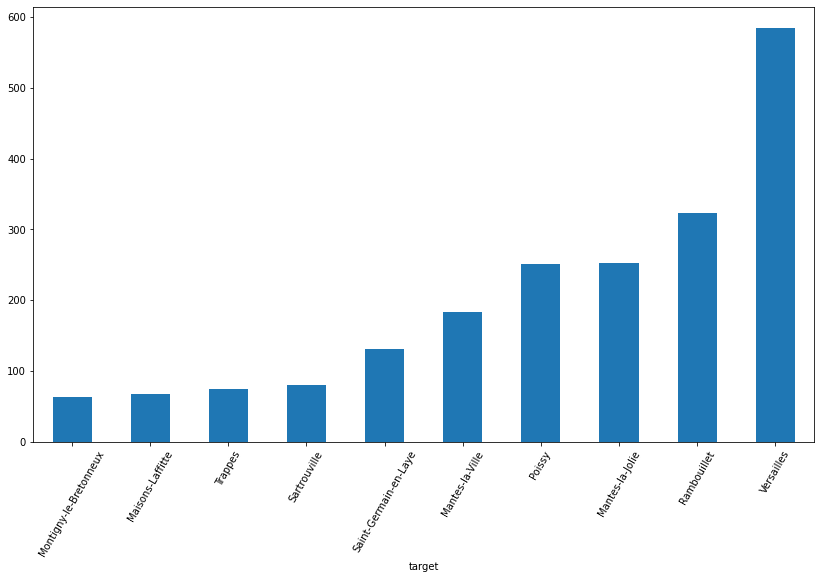

In [ ]:
liens.groupby('target').weight.sum().sort_values().tail(10).plot(kind='bar',rot=60,figsize=(14,8))

In [ ]:
#mercator projection
pos = polygons.to_crs('EPSG:3857').pipe(

                    lambda D : utils.pandas.Series(utils.numpy.c_[D.centroid.x.values,D.centroid.y.values].tolist(),
                                                   index=D.nom
                                                  )

).to_dict()

### Réseaux des villes co-citées

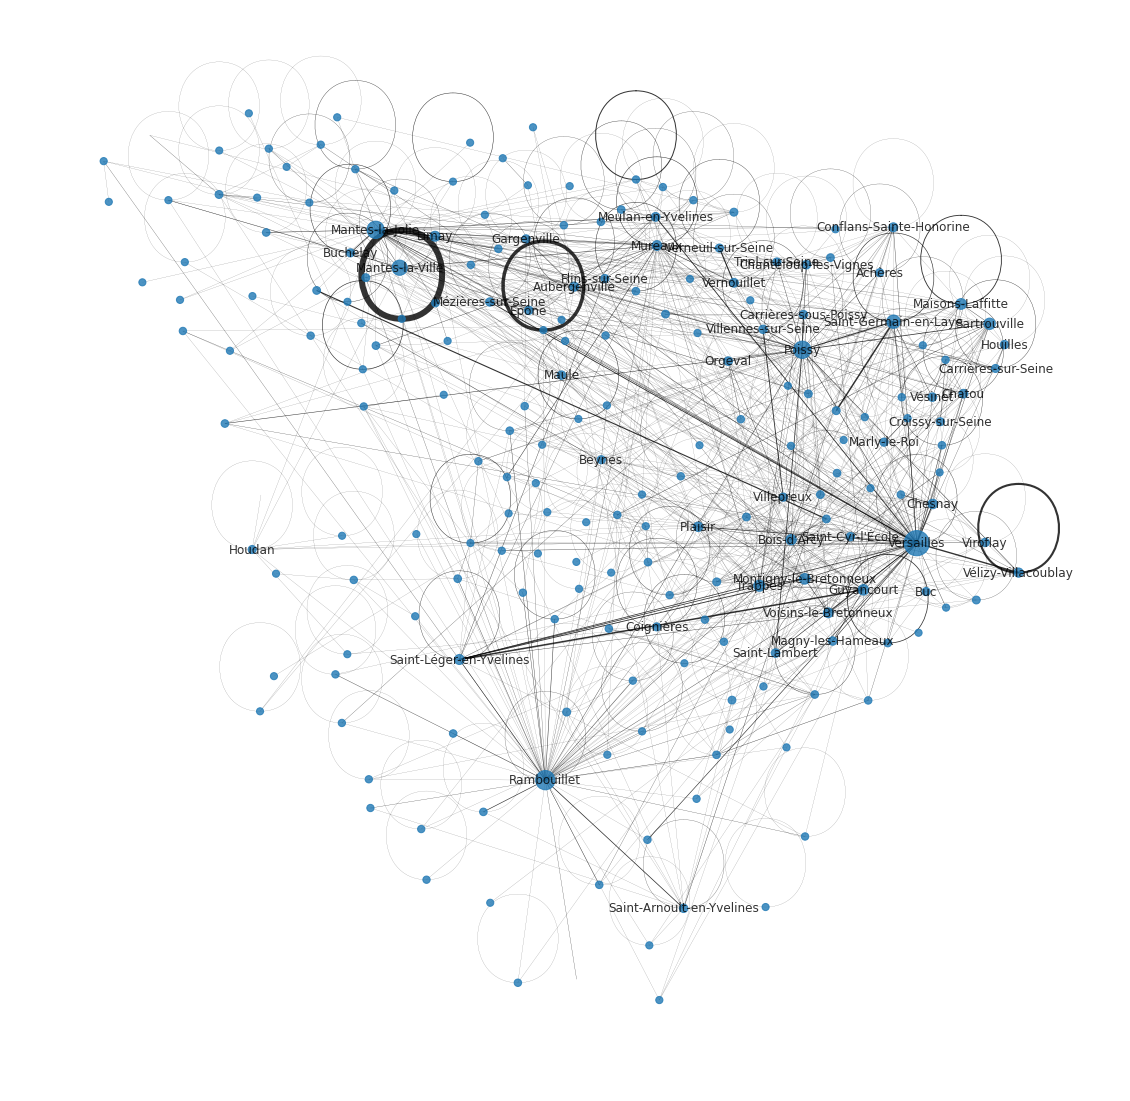

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

networkx.draw(G = G ,pos=pos,alpha = 0.8,with_labels=True,labels=nodes_labels,width=edges_sizes,node_size =nodes_sizes)

* la taille des cercles correspond au nombre de fois qu'une ville a été citée dans son article et par les autres

Le Top 3 des villes sur lesquelles les articles sont publiées(Mantes-la-Jolie,Versailles,Rambouillet) sont les plus co-citées avec cependant des relations circulaire moins fortes que d'autres villes moins citées.

Des villes voisines l'une à l'autre comme les Verneuil-sur-seine et Vernouillet sont fortement connectées.
Par contre, la proximité dans l'espace n'est pas un derterminant a priori significatif de la co-citation

# V°) Analyse des thèmes

### Tf-idf des lemmes

In [ ]:
Tmodeler = topics.TopicModeler(lemmas)
Tmodeler.Vectorize(f=utils.gensimtfid,kwargs={'params':{'max_df':.8, 'min_df':5}})
Tmodeler.V

,06,10,11,16,29,4,5,60,69,accueillir,...,appel_sanction,cao78,défense_entendre,examen_premier,fille_âgé_23,français_athlétisme,ile-de-france_athlétisme,lendemain_référer,lifa,obtenue
0,0.061918,0.022117,0.029547,0.025002,0.033983,0.024137,0.023521,0.040200,0.065721,0.050152,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.017414,0.000000,0.000000,0.000000,0.000000,0.000000,0.126611,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,0.000000,0.000000,0.000000,0.043645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1710,0.000000,0.000000,0.000000,0.057045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Choix du nombre de topics


In [ ]:
f = lambda V,n : utils.sklearntopicmodeler(V,n,method=NMF,params={'random_state':24,'init':'nndsvda','max_iter':500})

In [ ]:
scores = utils.pandas.DataFrame([ {**Tmodeler.GetTopics(ntopics=n,f=f).get_all_scores(),**{'n':n}} for n in utils.tqdm.tqdm(range(8,28))])

 75%|███████████████████████████████████████████████▎               | 15/20 [17:11<06:48, 81.70s/it]/home/akamara/venvs/d2sntxtmining/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/home/akamara/venvs/d2sntxtmining/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████| 20/20 [26:12<00:00, 78.61s/it]


<AxesSubplot:xlabel='n'>

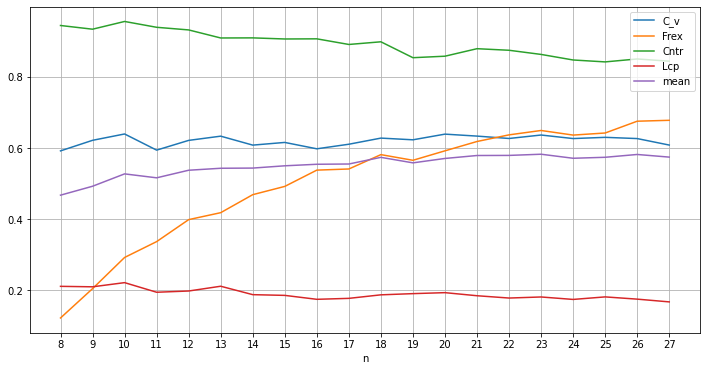

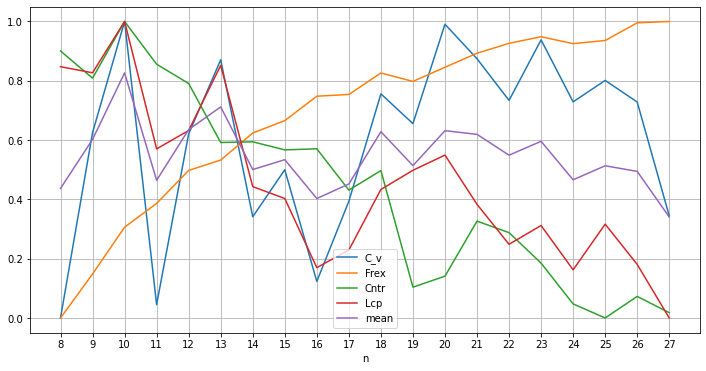

In [ ]:
scores.assign(Frex = lambda D : D.Frex - 19,Lcp =lambda D : -100/D.Lcp ).set_index('n').assign(mean=lambda D : D.mean(axis=1)).plot(figsize=(12,6),xticks=range(8,28),grid=True)
scores.set_index('n').pipe(lambda D: (D-D.min())/(D.max()-D.min())).assign(mean=lambda D : D.mean(axis=1)).plot(figsize=(12,6),xticks=range(8,28),grid=True)

## Résumé des topics

In [ ]:
n_topics = 19
Tmodeler.GetTopics(ntopics=n_topics,f=f,neutral_topic=True,discrim_ratio=0.7)
Tmodeler.summarize_topics(rawTx=Tx_raw().tolist())

/mnt/d_drive/data/vm/28122021/data/textmining_devoir/textmining/d2sntextmining/topics.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/mnt/d_drive/data/vm/28122021/data/textmining_devoir/textmining/d2sntextmining/topics.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
docstoptopics = Tmodeler.my.argmax(axis=1)
docstoptopics.shape

(1714,)

# V)  Regroupement des articles

## V.1°) projection doc2vec des articles

In [ ]:
tagged_lemmas               = [TaggedDocument(doc, [i]) for i, doc in enumerate(lemmas)]

for e in range(20,30):
    model                       = Doc2Vec(tagged_lemmas,alpha=0.05,vector_size=10,epochs=e,seed=13)


    Ds = 0
    ins = 0
    n = 30
    probs = 0
    for _id in list(random.randrange(0,len(lemmas)) for x in range(n)):
                v,vi = model[_id],model.infer_vector(lemmas[_id],epochs=32)
                D = sum((v-vi)**2)**.5
                Ds += D
                in_=0
                prob = 0
                try:
                    top = model.docvecs.most_similar([vi],topn=2)
                    ix,prs = [top[0][0],top[1][0]],[top[0][1],top[0][1]]
                    in_ = _id in ix
                    if in_:
                        prob = prs[ix.index(_id)]

                except KeyError:#not in vocab
                    pass
                ins+=in_
                probs += prob
    print(f'epochs {e}, dmean : {Ds/n} , coherence : {ins/n},probs :{probs/n }')

/home/akamara/venvs/d2sntxtmining/lib/python3.8/site-packages/gensim/models/doc2vec.py:535: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.



epochs 20, dmean : 2.620893857055195 , coherence : 0.9666666666666667,probs :0.9446341594060262
epochs 21, dmean : 2.2898676109494196 , coherence : 0.9666666666666667,probs :0.9473622818787892
epochs 22, dmean : 2.2402426488193776 , coherence : 1.0,probs :0.9849512159824372
epochs 23, dmean : 2.2427734001269304 , coherence : 1.0,probs :0.9853679955005645
epochs 24, dmean : 2.19521893618086 , coherence : 0.9666666666666667,probs :0.9546561241149902
epochs 25, dmean : 1.9604075285339457 , coherence : 1.0,probs :0.9844943900903066
epochs 26, dmean : 1.81482383304554 , coherence : 1.0,probs :0.9875889817873637
epochs 27, dmean : 1.9710583086771198 , coherence : 1.0,probs :0.9848727961381276
epochs 28, dmean : 1.8952183016488453 , coherence : 1.0,probs :0.9883470396200816
epochs 29, dmean : 1.6656740517347268 , coherence : 1.0,probs :0.9906610230604808


In [ ]:
model                       = Doc2Vec(tagged_lemmas,alpha=0.05,vector_size=10,epochs=29,seed=13)

In [ ]:
titre    = '''Incendie criminel du salon de coiffure de Mantes-la-Jolie : vers un classement sans suite de l'affaire'''
new_article='''Près de trois mois d’enquête et pas une piste solide. Les investigations sur l’incendie criminel du salon de coiffure MMB, en centre-ville de Mantes-la-Jolie, se dirigent tout droit vers un classement sans suite. Le 18 janvier, l’établissement, situé place de la République, avait été ravagé par les flammes. Un bidon d’essence gisait au milieu des décombres fumants, ne laissant planer aucun doute sur l’origine volontaire du sinistre.

Plusieurs hypothèses ont été exploitées par les enquêteurs. Celle d’un différend autour du bar clandestin aménagé au sous-sol, celle aussi d’une éventuelle arnaque à l’assurance, sans qu’aucune n’ait pu prospérer.

Dans les prochains jours, le dossier sera transmis au parquet de Versailles, qui, de source policière, devrait donc décider de le « classer sans suite » : « Les investigations de l’assurance et celles de nos services n’ont pas permis d’identifier un auteur ou de caractériser une fraude », avance un enquêteur.

Le 18 janvier vers 1h30 du matin, deux individus ont cassé une vitre sur le côté de l’établissement – au niveau du porche qui relie les places de la République et Saint-Jacques – avant de répandre de l’hydrocarbure à l’intérieur, d’y mettre le feu et de se volatiliser dans la nuit.

L'intérieur du salon a été entièrement ravagé par l'incendie.
L’intérieur du salon a été entièrement ravagé par l’incendie. (©Renaud Vilafranca)
Les pompiers ont lutté contre le sinistre jusqu’au petit matin. Les flammes, intenses, ont rapidement progressé, ravageant intégralement l’établissement, qui pourrait ne jamais rouvrir sous cette enseigne. Elles ont également endommagé les locaux d’une agence de courtage voisine, ainsi que la façade de l’immeuble qui surplombe les lieux. Plusieurs appartements ont aussi subi de légers dégâts.

Une trentaine d’habitants, très choqués, avaient été évacués en pleine nuit. Trois d’entre eux, légèrement intoxiqués par les fumées, ont fini aux urgences.

En inspectant l’endroit, les enquêteurs ont mis au jour une sorte de bar clandestin, aménagé au sous-sol du salon de coiffure. Un lieu qui, selon certains habitants, drainait depuis quelques mois une clientèle de gens peu fréquentables.

Un bar, avec banquettes et système de sonorisation, avait été aménagé au sous-sol, sans faire l'objet d'une déclaration officielle pour ce type d'activité.
Un bar, avec banquettes et système de sonorisation, avait été aménagé au sous-sol, sans faire l’objet d’une déclaration officielle pour ce type d’activité. (©DR)
L’entourage du gérant, contacté par téléphone il y a quelques mois, niait toute activité clandestine, évoquant une salle de réception « pour les proches » qui devait être déclarée prochainement. Le sort aura voulu qu’elle ne soit jamais officialisée… Les policiers s’étaient donc intéressés, en vain, à ce lieu, imaginant qu’il puisse être au centre d’une quelconque vengeance.

Au vu de certains éléments du dossier, ils avaient aussi envisagé que le gérant de l’établissement, dont le commerce était ouvert depuis un an, aurait pu être dans le coup. Son audition, menée cette semaine, n’a pas permis de confirmer cette piste.

Depuis le sinistre, le 18 janvier dernier, rien ne bouge autour du salon de coiffure. Aucun travaux de remise en état n'a pour l'instant été mené.
Depuis le sinistre, le 18 janvier dernier, rien ne bouge autour du salon de coiffure. Aucun travaux de remise en état n’a pour l’instant été mené. (©Renaud Vilafranca)
Quant aux deux silhouettes, celles des suspects, qui apparaissent sur les images de vidéosurveillance, impossible de mettre une identité dessus. Sauf rebondissement, ce dossier restera donc à jamais un mystère.'''

In [ ]:
nlpprocessor.process_texts(  raw_texts_list=[new_article],
                                      pipeargs = {'batch_size':28,'n_process':2}) #GN default []
nlpprocessor.extract_docs_attributes(max_workers=1)

newlemmas,_ = nlpprocessor.extract_docs_element(
                                                                col_name=keep_col,
                                                                filters=dq,
                                                                distinct_counts  = False,
                                                                languages = languages,
                                                            raw_texts_list = Tx_raw(),
                                                                for_loop=True)
Sfinder   = search.Finder(subs=gns)
found     = Sfinder.search(newlemmas)
newlemmas    = [utils.switcher(newlemmas[i],found.loc[i][(found.applymap(len)>0).loc[i]].values) for i,L in utils.tqdm.tqdm(enumerate(newlemmas))]

100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.09it/s]
1it [00:00, 12.44it/s]


In [ ]:
sims = model.docvecs.most_similar([model.infer_vector(newlemmas[0],epochs=52)])
sims

[(386, 0.9028262495994568),
 (1157, 0.8903945088386536),
 (1494, 0.8887530565261841),
 (325, 0.8816037774085999),
 (1082, 0.8812415599822998),
 (1015, 0.8749203085899353),
 (1352, 0.8714108467102051),
 (235, 0.8661029934883118),
 (1074, 0.8504116535186768),
 (73, 0.8436707258224487)]

In [ ]:
print(titre)
print('\n***similaires ?***')
querieddf().reset_index(drop=True).titre.loc[[x[0] for x in sims]].tolist()

Incendie criminel du salon de coiffure de Mantes-la-Jolie : vers un classement sans suite de l'affaire

***similaires ?***


['Yvelines. Alerte à la bombe au lycée Jules-Ferry de Versailles',
 'Yvelines. La mairie de Trappes victime d’une fausse alerte à la bombe',
 'Yvelines. Sartrouville : la police tombe dans un guet-apens',
 'Yvelines. Mantes-la-Jolie : le centre de vie sociale de nouveau visé par un incendie criminel',
 'Yvelines. Mantes-la-Jolie\xa0: un adepte de motocross entre la vie et la mort',
 "Yvelines. Sartrouville\xa0: encore un bus incendié cette nuit, c'est le cinquième en six mois",
 'Yvelines. Les Mureaux : en plein couvre-feu, une cinquantaine de personnes participent à une soirée chicha clandestine',
 'Mantes-la-Jolie\xa0: le salon de coiffure dévasté par un incendie criminel',
 'Yvelines. La gendarmerie met fin à une fête clandestine à Bonnières-sur-Seine',
 'Vélizy-Villacoublay : les cambrioleurs ont été vus par le voisin']

on retrouve un article précédents sur la même affaire du salon de coiffure incendié, un autre article dans la même ville portant sur un incendie



In [ ]:
mx = utils.pandas.DataFrame(map(lambda C : model[C],range(len(lemmas))))

In [ ]:
mx.shape

(1714, 10)

## V.3°) Regroupement par HDBSCAN

In [ ]:
grpr = hdbscan.HDBSCAN(min_cluster_size=4, metric='euclidean')
grpr.fit(utils.UMAP(n_components=5).fit_transform(mx))

HDBSCAN(min_cluster_size=4)

renommage des groupes par les 3 topics les plus fréquents

In [ ]:
groups_labels = utils.pandas.DataFrame(utils.numpy.c_[docstoptopics,grpr.labels_],columns=['topic','group']
                      ).groupby('group').apply(lambda X : list(f'{name}({p*100:.2f}%)' for p,name in zip(X.topic.value_counts().iloc[:3]/X.topic.shape[0],X.topic.value_counts().iloc[:3].index.to_series().map(Tmodeler.Tlabels).tolist()))).str.join(' ; ').to_dict()
groups_labels[-1]='non groupé'

In [ ]:
utils.pandas.DataFrame(zip(grpr.labels_,grpr.probabilities_),columns=['id','prb']).groupby('id').prb.agg(['count','mean']).sort_values('count',ascending=False).T

id,0,-1,21,33,24,28,32,19,9,17,...,23,22,31,34,35,11,10,7,30,3
count,820.000000,328.0,126.000000,57.000000,33.000000,28.000000,26.000000,22.000000,20.000000,19.000000,...,6.000000,6.000000,5.000000,5.000000,5.000000,4.0,4.0,4.0,4.0,4.0
mean,0.990827,0.0,0.972142,0.972962,0.754355,0.544363,0.723262,0.961437,0.850032,0.716767,...,0.994017,0.923957,0.990138,0.994598,0.996445,1.0,1.0,1.0,1.0,1.0


In [ ]:
grplabels  = list(map(lambda g : groups_labels[g],grpr.labels_))
grpcolors  = dict(zip(sorted(set(grplabels)),plot.px.colors.qualitative.Dark24+plot.px.colors.qualitative.Dark24_r))
grpcolors['non groupé'] = 'silver'

In [ ]:
grpcolors

{'accident voiture(100.00%)': '#2E91E5',
 'accident voiture(40.00%) ; élève école(26.67%) ; undefined(13.33%)': '#E15F99',
 'accident voiture(45.45%) ; undefined(36.36%) ; policier individu(18.18%)': '#1CA71C',
 'accident voiture(50.00%) ; adolescent vol(25.00%) ; undefined(12.50%)': '#FB0D0D',
 'accident voiture(70.18%) ; bus twitter(19.30%) ; undefined(5.26%)': '#DA16FF',
 'accident voiture(80.00%) ; undefined(20.00%)': '#222A2A',
 'adolescent vol(44.44%) ; animal chien(44.44%) ; undefined(11.11%)': '#B68100',
 'adolescent vol(46.83%) ; cannabis drogue(29.37%) ; undefined(19.05%)': '#750D86',
 'adolescent vol(71.43%) ; undefined(28.57%)': '#EB663B',
 'animal chien(87.50%) ; femme tribunal(12.50%)': '#511CFB',
 'femme tribunal(100.00%)': '#00A08B',
 'femme tribunal(50.00%) ; undefined(25.00%) ; adolescent vol(25.00%)': '#FB00D1',
 'femme tribunal(50.00%) ; undefined(50.00%)': '#FC0080',
 'femme tribunal(55.00%) ; undefined(25.00%) ; adolescent vol(20.00%)': '#B2828D',
 'femme tribunal

In [ ]:
Gparams    = {'hover_data':['index'],'color':'group','color_discrete_map':grpcolors,'width':800,'height':600}
Plt        = plot.Scatter(Gparams=Gparams,M=mx,reducer='UMAP')
Plt.M      = Plt.M.reset_index().assign(group=grplabels)

In [ ]:
Plt.plot2D({'marker':{'size': 4}})
Plt.plot3D({'marker':{'size': 2}})

La principale remarque qu'on fait est celle d'un clivage marqué entre articles parlant des projets urbains, marché de noel d'avec le reste des articles

## V.3°) Embedding Projector

In [ ]:
Plt.M[[0,1,2]].to_csv('./data/d2v_vectors.tsv',sep='\t',header=False,index=None)
Plt.M[['group']].assign(text=Tx_raw(),titre=querieddf().titre).to_csv('./data/d2v_metadata.tsv',sep='\t',index=None)

In [ ]:
%%HTML

<iframe src="https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/dourahmane/ced73013a0a6b3ea575456951dc12288/raw/f4b5aae6bea348c355b6f270ccfd4e0960e69ef9/config.json" style="width: 1200px; height: 900px;"></iframe>

## V.3°) Géographie des groupes

In [ ]:
liensg = utils.pandas.DataFrame([ (g,replace_name['_'.join(to_triplet_list(v))] ,replace_name[RenameDict[entity]] )
    for v,doc_entities,g in zip(villes_in_docs,entities,grplabels)
    for entity in doc_entities
    if entity in RenameDict and '_'.join(to_triplet_list(v)) in replace_name
                                         ],columns=['group','source','target']
                              ).groupby(['group','source','target']).size().reset_index().rename(columns={0:'weight'})

In [ ]:
indegreeg = liensg.groupby(['target','group']).weight.sum().reset_index().pivot_table(index='target',columns='group',values='weight',aggfunc='sum').fillna(0)
indegreeg

group,accident voiture(100.00%),accident voiture(40.00%) ; élève école(26.67%) ; undefined(13.33%),accident voiture(45.45%) ; undefined(36.36%) ; policier individu(18.18%),accident voiture(50.00%) ; adolescent vol(25.00%) ; undefined(12.50%),accident voiture(70.18%) ; bus twitter(19.30%) ; undefined(5.26%),accident voiture(80.00%) ; undefined(20.00%),adolescent vol(44.44%) ; animal chien(44.44%) ; undefined(11.11%),adolescent vol(46.83%) ; cannabis drogue(29.37%) ; undefined(19.05%),adolescent vol(71.43%) ; undefined(28.57%),animal chien(87.50%) ; femme tribunal(12.50%),...,undefined(50.00%) ; policier individu(25.00%) ; accident voiture(25.00%),undefined(50.00%) ; policier individu(25.00%) ; bus twitter(12.50%),undefined(50.00%) ; prime patient(25.00%) ; femme tribunal(25.00%),undefined(53.57%) ; femme tribunal(21.43%) ; adolescent vol(10.71%),undefined(54.55%) ; bus twitter(18.18%) ; adolescent vol(9.09%),undefined(58.33%) ; femme tribunal(16.67%) ; animal chien(16.67%),undefined(66.67%) ; bus twitter(33.33%),undefined(75.00%) ; accident voiture(25.00%),valbuena benzema(60.00%) ; femme tribunal(33.33%) ; undefined(6.67%),élève école(85.71%) ; undefined(14.29%)
target,,,,,,,,,,,,,,,,,,,,,
Achères,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adainville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aigremont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andelu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andrésy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Élancourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Émancé,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Épône,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
posvals       = list(pos.values())
angles_colors = indegreeg.pipe(lambda D : D.div(D.sum(axis=1),axis=0).cumsum(axis=1)*360).apply(lambda row : dict(zip(zip([0]+row.values.tolist(),row.values),grpcolors.values())),axis=1).to_dict()
w,h           = (900,1100)
g             = (w/2,h/2)
mx0,mx1       = max(posvals,key=lambda x : x[0])[0],max(posvals,key=lambda x : x[1])[1]
mn0,mn1       = min(posvals,key=lambda x : x[0])[0],min(posvals,key=lambda x : x[1])[1]
scale         = lambda v,ref,mn,mx : ((v-mn)/(mx-mn))*ref
cstyle        = {'fill':'none','stroke':'black','stroke-opacity':0.5}

DCirle        = lambda r,coord,cstyle=cstyle : plot.Circle(center=coord, r=r,**cstyle)
euclid        = lambda a,b=g :((a[0]-b[0])**2+(a[1]-b[1])**2)**.5
doc           = plot.svg.Drawing(filename = "pies.svg",  size=(f"{w}px",f"{h}px"))
Ccor          = lambda teta,r : (r*utils.math.cos(utils.math.radians(teta)),r*utils.math.sin(utils.math.radians(teta)))
def triangle(arcO,v,c,r,name):
    g         = plot.Group(id=name)
    to_str = lambda c : ' '.join(str(x) for x in c)
    O0,O1 = arcO
    dO    = O1-O0
    c0,c1 = Ccor(O0,r),Ccor(O1,r)
    c0,c1 = (c[0]+c0[0],c[1]+c0[1]),(c[0]+c1[0],c[1]+c1[1])
    path  = (f"M {to_str(c1)}"
             f" L {to_str(c)}"
             f" L{to_str(c0)}"
             f" A {r},{r},0,{(1,0)[dO<=180]},1, {to_str(c1)}"
             f" L {to_str(c)}")
    g.add(plot.svg.path.Path(d=path,fill=('none',v)[dO>0]))
    return g

mndeg,mxdeg = min(indegree.values()),max(indegree.values())
for name,(x,y) in list(zip(pos,posvals)):
    wp,hp=800,1100
    middle = hp/2
    ydif   = scale(y,hp,mn1,mx1) - middle
    p      = (scale(x,wp,mn0,mx0),scale(y,hp,mn1,mx1)-2*ydif)
    indeg = 0 if name not in indegree else indegree[name]
    if indeg>10: #only more than 20
        r = max(8,scale(indeg,40,10,mxdeg))
        c = DCirle(r,p)
        doc.add(c)
        name_vals = indegreeg.loc[name].sort_values()
        name_sum = name_vals.sum()
        second_fill = grpcolors[name_vals.index.to_series().iloc[-2]]
        label     = plot.Text(name, insert=(p[0]-r,p[1]-r),font_size=8,font_weight='bold',fill=second_fill)
        doc.add(label)
        for arc,v in angles_colors[name].items():
            doc.add(triangle(arc,v,c=p,r=r,name=name))
            if arc[1]-arc[0] == 360 :c.fill(v)


/tmp/ipykernel_18845/2130678232.py:21: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

/tmp/ipykernel_18845/2130678232.py:26: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [ ]:
grpcolors

{'accident voiture(100.00%)': '#2E91E5',
 'accident voiture(40.00%) ; élève école(26.67%) ; undefined(13.33%)': '#E15F99',
 'accident voiture(45.45%) ; undefined(36.36%) ; policier individu(18.18%)': '#1CA71C',
 'accident voiture(50.00%) ; adolescent vol(25.00%) ; undefined(12.50%)': '#FB0D0D',
 'accident voiture(70.18%) ; bus twitter(19.30%) ; undefined(5.26%)': '#DA16FF',
 'accident voiture(80.00%) ; undefined(20.00%)': '#222A2A',
 'adolescent vol(44.44%) ; animal chien(44.44%) ; undefined(11.11%)': '#B68100',
 'adolescent vol(46.83%) ; cannabis drogue(29.37%) ; undefined(19.05%)': '#750D86',
 'adolescent vol(71.43%) ; undefined(28.57%)': '#EB663B',
 'animal chien(87.50%) ; femme tribunal(12.50%)': '#511CFB',
 'femme tribunal(100.00%)': '#00A08B',
 'femme tribunal(50.00%) ; undefined(25.00%) ; adolescent vol(25.00%)': '#FB00D1',
 'femme tribunal(50.00%) ; undefined(50.00%)': '#FC0080',
 'femme tribunal(55.00%) ; undefined(25.00%) ; adolescent vol(20.00%)': '#B2828D',
 'femme tribunal

In [ ]:
#'<table class="table"><tbody><tr><th>Color</th><th>Label</th></tr> {}</tbody></table>'.format(''.join(f'<tr><td style="background-color:{grpcolors[g]}"></td><td>{g}</td></tr>' for g in grpcolors))

In [ ]:
%%HTML
<table class="table"><tbody><tr><th>Color</th><th>Label</th></tr> <tr><td style="background-color:#2E91E5"></td><td>accident voiture(100.00%)</td></tr><tr><td style="background-color:#E15F99"></td><td>accident voiture(40.00%) ; élève école(26.67%) ; undefined(13.33%)</td></tr><tr><td style="background-color:#1CA71C"></td><td>accident voiture(45.45%) ; undefined(36.36%) ; policier individu(18.18%)</td></tr><tr><td style="background-color:#FB0D0D"></td><td>accident voiture(50.00%) ; adolescent vol(25.00%) ; undefined(12.50%)</td></tr><tr><td style="background-color:#DA16FF"></td><td>accident voiture(70.18%) ; bus twitter(19.30%) ; undefined(5.26%)</td></tr><tr><td style="background-color:#222A2A"></td><td>accident voiture(80.00%) ; undefined(20.00%)</td></tr><tr><td style="background-color:#B68100"></td><td>adolescent vol(44.44%) ; animal chien(44.44%) ; undefined(11.11%)</td></tr><tr><td style="background-color:#750D86"></td><td>adolescent vol(46.83%) ; cannabis drogue(29.37%) ; undefined(19.05%)</td></tr><tr><td style="background-color:#EB663B"></td><td>adolescent vol(71.43%) ; undefined(28.57%)</td></tr><tr><td style="background-color:#511CFB"></td><td>animal chien(87.50%) ; femme tribunal(12.50%)</td></tr><tr><td style="background-color:#00A08B"></td><td>femme tribunal(100.00%)</td></tr><tr><td style="background-color:#FB00D1"></td><td>femme tribunal(50.00%) ; undefined(25.00%) ; adolescent vol(25.00%)</td></tr><tr><td style="background-color:#FC0080"></td><td>femme tribunal(50.00%) ; undefined(50.00%)</td></tr><tr><td style="background-color:#B2828D"></td><td>femme tribunal(55.00%) ; undefined(25.00%) ; adolescent vol(20.00%)</td></tr><tr><td style="background-color:#6C7C32"></td><td>femme tribunal(66.67%) ; undefined(33.33%)</td></tr><tr><td style="background-color:#778AAE"></td><td>femme tribunal(92.86%) ; undefined(7.14%)</td></tr><tr><td style="background-color:#862A16"></td><td>incendie pompier(100.00%)</td></tr><tr><td style="background-color:#A777F1"></td><td>incendie pompier(65.38%) ; bus twitter(23.08%) ; undefined(7.69%)</td></tr><tr><td style="background-color:silver"></td><td>non groupé</td></tr><tr><td style="background-color:#1616A7"></td><td>noël marché(23.05%) ; undefined(21.34%) ; projet ville(17.32%)</td></tr><tr><td style="background-color:#DA60CA"></td><td>policier individu(50.00%) ; undefined(27.27%) ; adolescent vol(13.64%)</td></tr><tr><td style="background-color:#6C4516"></td><td>policier individu(50.00%) ; undefined(33.33%) ; élève école(16.67%)</td></tr><tr><td style="background-color:#0D2A63"></td><td>policier individu(66.67%) ; bus twitter(22.22%) ; undefined(11.11%)</td></tr><tr><td style="background-color:#AF0038"></td><td>policier individu(70.00%) ; accident voiture(20.00%) ; incendie pompier(10.00%)</td></tr><tr><td style="background-color:#AF0038"></td><td>policier individu(78.95%) ; undefined(15.79%) ; accident voiture(5.26%)</td></tr><tr><td style="background-color:#0D2A63"></td><td>undefined(30.30%) ; policier individu(21.21%) ; adolescent vol(18.18%)</td></tr><tr><td style="background-color:#6C4516"></td><td>undefined(41.18%) ; adolescent vol(29.41%) ; femme tribunal(17.65%)</td></tr><tr><td style="background-color:#DA60CA"></td><td>undefined(50.00%) ; policier individu(25.00%) ; accident voiture(25.00%)</td></tr><tr><td style="background-color:#1616A7"></td><td>undefined(50.00%) ; policier individu(25.00%) ; bus twitter(12.50%)</td></tr><tr><td style="background-color:#620042"></td><td>undefined(50.00%) ; prime patient(25.00%) ; femme tribunal(25.00%)</td></tr><tr><td style="background-color:#A777F1"></td><td>undefined(53.57%) ; femme tribunal(21.43%) ; adolescent vol(10.71%)</td></tr><tr><td style="background-color:#862A16"></td><td>undefined(54.55%) ; bus twitter(18.18%) ; adolescent vol(9.09%)</td></tr><tr><td style="background-color:#778AAE"></td><td>undefined(58.33%) ; femme tribunal(16.67%) ; animal chien(16.67%)</td></tr><tr><td style="background-color:#6C7C32"></td><td>undefined(66.67%) ; bus twitter(33.33%)</td></tr><tr><td style="background-color:#B2828D"></td><td>undefined(75.00%) ; accident voiture(25.00%)</td></tr><tr><td style="background-color:#FC0080"></td><td>valbuena benzema(60.00%) ; femme tribunal(33.33%) ; undefined(6.67%)</td></tr><tr><td style="background-color:#FB00D1"></td><td>élève école(85.71%) ; undefined(14.29%)</td></tr></tbody></table>


Color,Label
,accident voiture(100.00%)
,accident voiture(40.00%) ; élève école(26.67%) ; undefined(13.33%)
,accident voiture(45.45%) ; undefined(36.36%) ; policier individu(18.18%)
,accident voiture(50.00%) ; adolescent vol(25.00%) ; undefined(12.50%)
,accident voiture(70.18%) ; bus twitter(19.30%) ; undefined(5.26%)
,accident voiture(80.00%) ; undefined(20.00%)
,adolescent vol(44.44%) ; animal chien(44.44%) ; undefined(11.11%)
,adolescent vol(46.83%) ; cannabis drogue(29.37%) ; undefined(19.05%)
,adolescent vol(71.43%) ; undefined(28.57%)
,animal chien(87.50%) ; femme tribunal(12.50%)


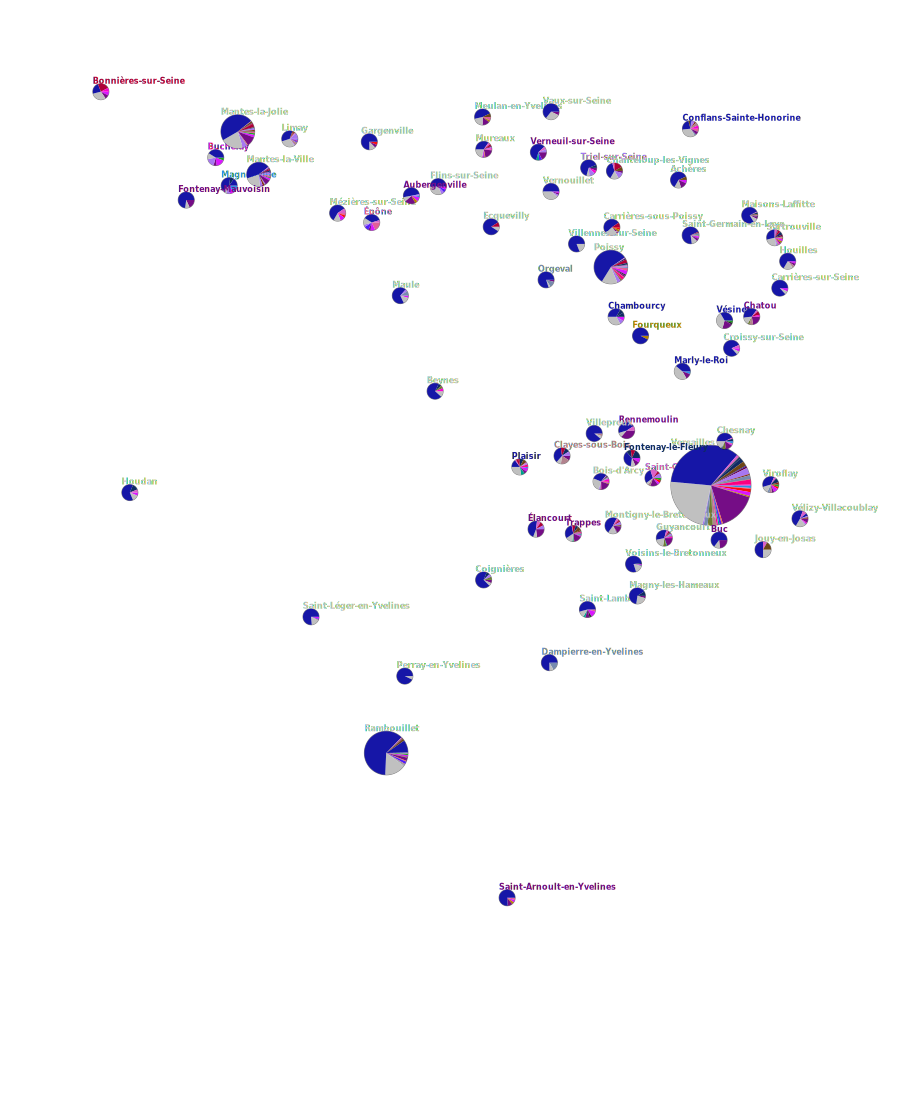

In [ ]:
doc